<a href="https://colab.research.google.com/github/cammaral/fpm-criteria/blob/main/C%C3%B3pia_de_cidades_novo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.formula.api import ols
import geopandas as gpd
from scipy.interpolate import *
%matplotlib inline
from scipy.stats import linregress
from numpy.polynomial.polynomial import polyfit
from scipy.optimize import curve_fit
from pylab import *
from matplotlib.gridspec import GridSpec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.gridspec as gridspec
import matplotlib.cm as cm
from matplotlib.legend_handler import HandlerLine2D

# 1. Coleta de dados

Para realizar o tratamento dos dados que serão utilizados, inicialmente, removemos as capitais e as cidades que não possuimos os dados de *População* e/ou *PIB* ao longo dos anos de 2010 até 2024. Com isso, resultamos em um total de 5.488 municípios.

In [ ]:
data1 = (
    pd.read_csv("populacao_municipal_2010_2024.csv", na_values=["#N/DISP"])
    # Remover linhas com NaN nas colunas de população e PIB
    .dropna(subset=[f'populacao_{ano}' for ano in range(2012, 2022)] +
                  [f'pib_{ano}' for ano in range(2012, 2022)])
    # Transformar a coluna 'capital' em string
    .assign(capital=lambda df: df['capital'].astype(str))
    # Remover capitais
    .query("capital != 'True'")
)

print(f'Número total de municípios: {len(data1)}')

Número total de municípios: 5488


In [ ]:
#--------- Distribuição do FPM pelos método antigo e novo ---------#
montante = 53000000000
eta = data1['eta'].str.replace(',', '.').astype(float).dropna() / 100

#--------- Função para calcular GINI ---------#

def gini_lorenz(values, plot=False):
    """Calcula o coeficiente de Gini via área sob a Curva de Lorenz."""
    values = np.sort(values)  # Ordena os valores
    N = len(values)
    cum_values = np.cumsum(values) / np.sum(values)  # Normaliza soma total
    cum_pop = np.arange(1, N + 1) / N  # Percentual acumulado da população
    B = np.trapz(cum_values, cum_pop)  # Integral numérica (método do trapézio)
    #print(C)
    # Coeficiente de Gini
    gini = 1 - 2 * B
    if plot:
        plt.figure(figsize=(6,6))
        plt.plot(cum_pop, cum_values, label="Curva de Lorenz", color="blue")
        plt.plot([0,1], [0,1], linestyle="--", color="red", label="Igualdade Perfeita")  # Linha de 45°
        plt.fill_between(cum_pop, cum_values, cum_pop, color="blue", alpha=0.2)  # Área entre as curvas
        plt.xlabel("População acumulada (%)")
        plt.ylabel("FPM acumulado (%)")
        plt.title(f"Curva de Lorenz (Gini = {gini:.4f}, Gini Antigo = {gini_antigo:.4f})")
        plt.legend()
        plt.show()

    return gini

In [ ]:
print(eta)

0       0.007464
1       0.007464
2       0.007464
3       0.007464
4       0.007464
          ...   
5559    0.037318
5560    0.037318
5561    0.037318
5562    0.037318
5563    0.037318
Name: eta, Length: 5488, dtype: float64


## 2 - Proposta 1: Utilizar do PIB como critério
Ao utilizarmos a *População* para realizar a distribuição do *FPM* acabamos tendo o problema de que o CENSO é realizado a cada decada. Isto é, as cidades ficam dependentes de estimativas de popuplação ao invés do valor exato. Para contornar esse problema, podemos utilizar do *PIB* de cada cidade que é calculado anualmente, apesar de possuir uma atraso de publicação entre 2~3 anos.

Inicialmente, utilizamos duas propostas: uma nova Tabela de distribuição do *FPM* baseada no *PIB* fixa e outra que é ajustada anualmente.
Em ambos os casos, montamos tal tabela usando a Lei de Potencia que conecta o *PIB* com a *População* ($N$), dado por

\begin{equation*}
    PIB = N_{0} \times N^{\beta},
\end{equation*}

onde $N_{0}$ e $\beta$ são parâmetros a serem ajustados que variam a cada ano. Idealmente $\beta=1,15$, mas como veremos, no caso brasileiro $\beta=1,05$.

### 2.1 - Tabela Fixa
Para a construção da Tabela Fixa, utilizamos da *População* do ano inicial, 2016, para obter *PIB* através da Lei de Potência comentada. Assim, a mesmo tabela é utilizada ao longo dos anos.

In [ ]:
#--------- Dados necessários para calcular a nova tabela ---------#

data_list = [data1[[f"pib_{2010 + i}", f"populacao_{2010 + i}"]] for i in range(12)] # PIB e POP. (2010 ~ 2021)

data_list = [
    data.apply(pd.to_numeric, errors='coerce').loc[
        lambda df: (df[f"pib_{2010 + i}"] >= 1) & (df[f"populacao_{2010 + i}"] >= 1)
    ]
    for i, data in enumerate(data_list)
] # Filtragem para converter em numérico e remover vazios e nulos - Não teve problemas, por isso o número de cidades é mantido o mesmo

faixas_lambdas = (
    pd.read_csv("populacao_municipal_2010_2024.csv")
    .loc[:,['faixa_1','faixa_2','lambda']].dropna()
    ) # Obtém as faixas no modo atual

pib = {f"pib_{2010 + i}": data_list[i][f"pib_{2010 + i}"].dropna() for i in range(12)} # PIB por ano
pop = {f"pop_{2010 + i}": data_list[i][f"populacao_{2010 + i}"].dropna() for i in range(12)} # POP. por ano

Aqui, é necessário verificar qual o valor de $\beta$ para o caso do Brasil. Assim, realizando o fit utilizando a expressão
\begin{equation}
    ln(PIB) = \beta ln(N) + ln(N_0)
\end{equation}
encontramos $\beta = 1,05 \pm  0,03$. Assim, fixamos esse valor e calculamos novamente $N_0$ com $\beta$ fixo. Como tentaremos mudar essa tabela de forma dinâmica mais pra frente, aqui já calculamos também para outros anos que não são apenas em 2010.

In [ ]:
#--------- Fit da curva para obter N0 e beta variável ---------#

p_list = [
    np.polyfit(np.log(pop[f"pop_{2010 + i}"]) , np.log(pib[f"pib_{2010 + i}"]), 1)
    for i in range(12)
]

z_list = [
    np.polyval(p_list[i], np.log(pop[f"pop_{2010 + i}"]))
    for i in range(12)
]

media_beta = np.mean([p[0] for p in p_list])
inc_beta = 0.5*(np.max([p[0] for p in p_list]) - np.min([p[0] for p in p_list]))
media_n0 = np.mean(np.exp([p[1] for p in p_list]))
inc_n0 = 0.5*(np.max(np.exp([p[1] for p in p_list])) - np.min(np.exp([p[1] for p in p_list])))

print(f'Valor de beta médio: {np.round(media_beta,2)} +/- {np.round(inc_beta,2)}')
print(f'Valor de N0 médio: {np.round(media_n0,2)} +/- {np.round(inc_n0,2)}')

N_ev = np.exp([p[1] for p in p_list]) #N0 com beta variável


Valor de beta médio: 1.05 +/- 0.03
Valor de N0 médio: 10.75 +/- 8.9


In [ ]:
#--------- Obter N0 com beta fixo ---------#

beta_fixo = 1.05
log_N0_list = [
    np.mean(np.log(pib[f"pib_{2010 + i}"]) - beta_fixo * np.log(pop[f"pop_{2010 + i}"]))
    for i in range(12)
]

# Média e incerteza de log(N0)
media_N0 = np.mean(np.exp(log_N0_list))
inc_N0 = 0.5 * (np.max(np.exp(log_N0_list)) - np.min(np.exp(log_N0_list)))
N_ev_novo = np.exp(log_N0_list) # N0 com beta fixo

print(f'Valor de N0 médio: {np.round(media_N0, 2)} +/- {np.round(inc_N0, 2)}')



Valor de N0 médio: 9.81 +/- 4.62


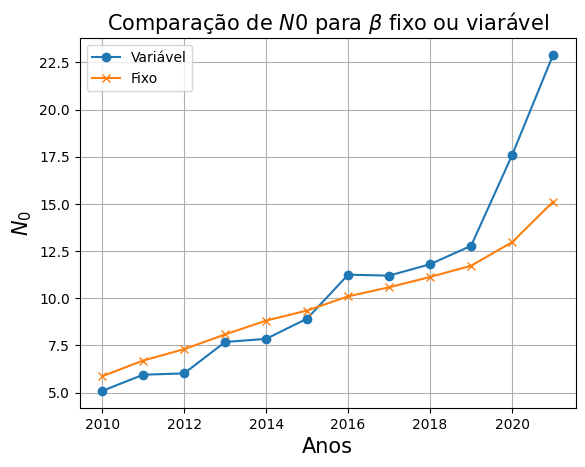

In [ ]:
#--------- Comparação entre os N0 obtidos ---------#

plt.plot(range(2010,2022), N_ev, 'o-',label='Variável')
plt.plot(range(2010,2022), N_ev_novo, 'x-',label='Fixo')
plt.title('Comparação de $N0$ para $\\beta$ fixo ou viarável', fontsize= 15)
plt.xlabel('Anos', fontsize= 15)
plt.ylabel('$N_{0}$', fontsize= 15)
plt.grid()
plt.legend()
plt.show()

Com o valor de $\beta$ fixo, utilizamos a Tabela de Atribuição de $\lambda$ baseado na população e mudamos cada um dos valores das faixas usando a Lei de Potencia, obtendo uma tabela baseada no *PIB*. Porém, é necessário fazer uma pequena correção, onde pegamos o limite inferior da faixa superior anterior e adicionamos um centavo.

In [ ]:
print('Atribuição baseada em população')
faixas_lambdas

Atribuição baseada em população


,faixa_1,faixa_2,lambda
0,0.0,1.018700e+04,"0,6"
1,10188.0,1.358300e+04,"0,8"
2,13584.0,1.697900e+04,1
3,16980.0,2.373200e+04,"1,2"
4,23733.0,3.056300e+04,"1,4"
5,30564.0,3.735500e+04,"1,6"
6,37356.0,4.414700e+04,"1,8"
7,44148.0,5.094000e+04,2
8,50941.0,6.112700e+04,"2,2"
9,61128.0,7.131500e+04,"2,4"


In [ ]:
#--------- Encontra nova tabela fixa (2010) para beta fixo e N0 ---------#

anos = range(12)

tabela_p1_fixa = {}

N0 = N_ev_novo[0]
tabela_p1_fixa = pd.DataFrame({
    "faixa_1": np.round(N0 * (faixas_lambdas["faixa_1"] ** beta_fixo),2),
    "faixa_2": np.round(N0 * (faixas_lambdas["faixa_2"] ** beta_fixo),2),
    'lambda': faixas_lambdas["lambda"]
})
tabela_p1_fixa.loc[1:, "faixa_1"] = tabela_p1_fixa["faixa_2"].shift(1) + 0.01  # Soma de R$0,01

In [ ]:
print('Atribuição baseada no PIB com Tabela Fixa')
tabela_p1_fixa

Atribuição baseada no PIB com Tabela Fixa


,faixa_1,faixa_2,lambda
0,0.00,9.484412e+04,"0,6"
1,94844.13,1.282943e+05,"0,8"
2,128294.29,1.621696e+05,1
3,162169.63,2.304957e+05,"1,2"
4,230495.72,3.006198e+05,"1,4"
5,300619.81,3.711316e+05,"1,6"
6,371131.64,4.422910e+05,"1,8"
7,442290.96,5.140125e+05,2
8,514012.51,6.224529e+05,"2,2"
9,622452.96,7.318157e+05,"2,4"


Com isso, verificamos como está distribuição das faixas de atribuição de $\lambda$ ao longo dos anos e como o *PIB* das cidades está distribuido em cada ano. No gráfico abaixo, vemos que existem cidades que estão muito distantes dos valores dessas faixas.

<>:9: SyntaxWarning: invalid escape sequence '\l'
<>:9: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-293799198.py:9: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('$\log_{10}(PIB_{min})$', fontsize=15)


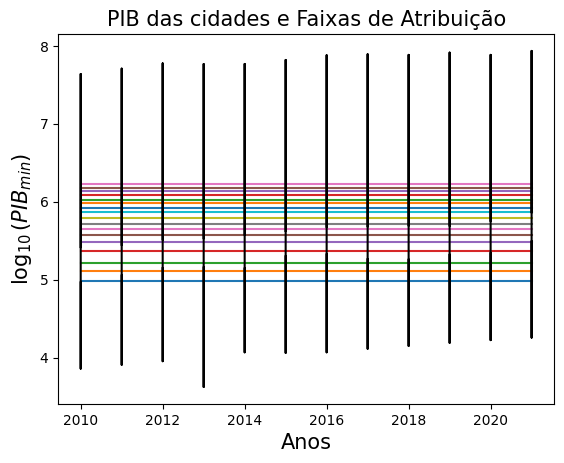

In [ ]:
for j in range(1,18):
    plotar = [tabela_p1_fixa['faixa_1'][j] for i in range(12)]
    plt.plot(range(2010,2022), np.log10(plotar))
for ano in range(2010, 2022):
    plt.plot([ano]*len(pib[f'pib_{ano}']), np.log10(pib[f'pib_{ano}']), color='black')

plt.title('PIB das cidades e Faixas de Atribuição', fontsize=15)
plt.xlabel('Anos', fontsize=15)
plt.ylabel('$\log_{10}(PIB_{min})$', fontsize=15)
plt.show()

Agora, atribuimos valores de $\lambda$ para as cidades e verificamos como está a distribuição ao longo dos anos.

In [ ]:
#--------- Atribuição de valores de de lambda ---------#

def atribuir_lambda_p1_fixo(valor):
    for _, row in tabela_p1_fixa.iterrows():
        faixa_1 = float(row['faixa_1'])
        faixa_2 = float(row['faixa_2'])
        if faixa_1 <= float(valor) <= faixa_2:
            return float(row['lambda'].replace(",", "."))
    print(float(valor) <= faixa_2, faixa_2)
    return None

for i in range(0, 12):
    data1[f'p1_fixa{2010+i}'] =  data1[f'pib_{2010+i}'].apply(lambda x: atribuir_lambda_p1_fixo(x))

<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:5: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:5: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-979315418.py:4: SyntaxWarning: invalid escape sequence '\l'
  plt.title('Distribuição das cidades por $\lambda$ atribuido', fontsize=15)
/tmp/ipython-input-979315418.py:5: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$', fontsize=15)


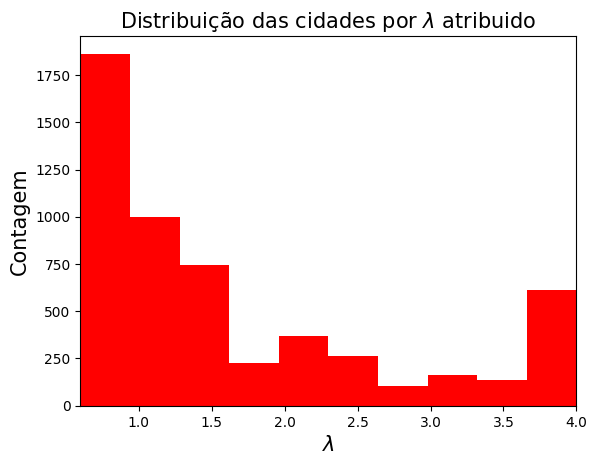

In [ ]:
ano = 2020
plt.hist(data1[f'p1_fixa{ano}'], color='red')
#plt.hist(data1[f'lambda_antigo_{ano}'], color='black',alpha=0.5)
plt.title('Distribuição das cidades por $\lambda$ atribuido', fontsize=15)
plt.xlabel('$\lambda$', fontsize=15)
plt.ylabel('Contagem', fontsize=15)
plt.xlim(0.6, 4)
plt.show()

<>:12: SyntaxWarning: invalid escape sequence '\l'
<>:14: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\l'
<>:14: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-485469197.py:12: SyntaxWarning: invalid escape sequence '\l'
  ax.set_title('Distribuição das cidades por $\lambda$ atribuído', fontsize=15)
/tmp/ipython-input-485469197.py:14: SyntaxWarning: invalid escape sequence '\s'
  ax.set_ylabel('$\sigma^2$', fontsize=15)


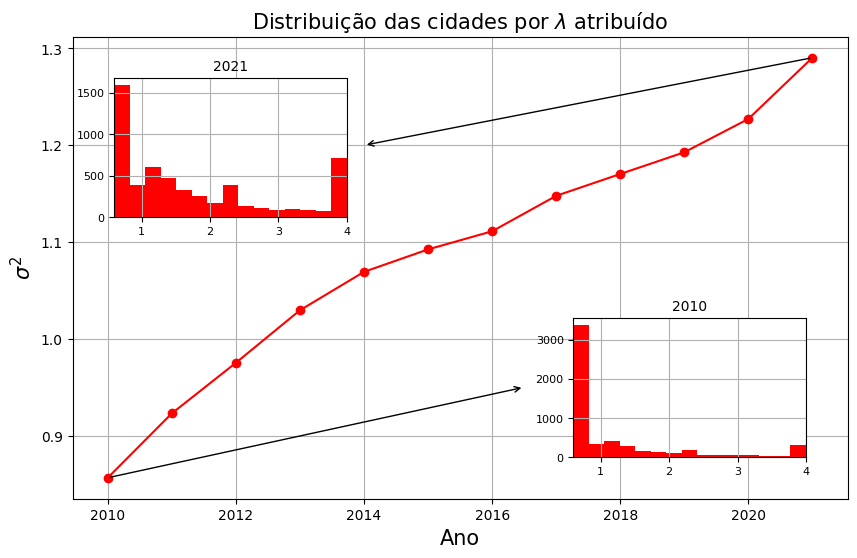

In [ ]:
# Lista de anos
anos = list(range(2010, 2022))

# Variância para cada ano
variancias0 = [data1[f'p1_fixa{ano}'].var() for ano in anos]

# Cria a figura e o eixo principal
fig, ax = plt.subplots(figsize=(10, 6))

# Gráfico principal
ax.plot(anos, variancias0, color='red', marker='o')
ax.set_title('Distribuição das cidades por $\lambda$ atribuído', fontsize=15)
ax.set_xlabel('Ano', fontsize=15)
ax.set_ylabel('$\sigma^2$', fontsize=15)
ax.grid(True)

# --- Inserindo o primeiro histograma (primeiro ano) ---
axins1 = inset_axes(ax, width="30%", height="30%", loc='lower right', borderpad=3)
ano_inicio = anos[0]  # Primeiro ano
axins1.hist(data1[f'p1_fixa{ano_inicio}'], color='red', bins=15)
axins1.set_xlim(0.6, 4)
axins1.set_title(f'{ano_inicio}', fontsize=10)
axins1.tick_params(axis='both', which='major', labelsize=8)
axins1.grid(True)

# --- Inserindo o segundo histograma (último ano) ---
axins2 = inset_axes(ax, width="30%", height="30%", loc='upper left', borderpad=3)
ano_fim = anos[-1]  # Último ano
axins2.hist(data1[f'p1_fixa{ano_fim}'], color='red', bins=15)
axins2.set_xlim(0.6, 4)
axins2.set_title(f'{ano_fim}', fontsize=10)
axins2.tick_params(axis='both', which='major', labelsize=8)
axins2.grid(True)

# --- Criando setas do ponto da curva para o histograma ---
# Ponto da curva para o primeiro ano
ax.annotate('', xy=(ano_inicio, variancias0[0]), xytext=(2016.5, 0.95),
            arrowprops=dict(facecolor='black', arrowstyle='<-'))

# Ponto da curva para o último ano
ax.annotate('', xy=(ano_fim, variancias0[-1]), xytext=(2014, 1.2),
            arrowprops=dict(facecolor='black', arrowstyle='<-'))

plt.show()

### 2.2 - Tabela Variável
De forma mais direta, agora veremos os mesmos resultados, mas com a tabela variando a cada ano.

In [ ]:
#--------- Encontra novas tabelas (cada ano) para beta fixo e N0 ---------#

anos = range(12)
tabelas_p1_var = {}

for ano in anos:
    N0 = N_ev_novo[ano]
    df_pib = pd.DataFrame({
        "faixa_1": np.round(N0 * (faixas_lambdas["faixa_1"] ** beta_fixo), 2),
        "faixa_2": np.round(N0 * (faixas_lambdas["faixa_2"] ** beta_fixo), 2),
        'lambda': faixas_lambdas["lambda"]
    })
    df_pib.loc[1:, "faixa_1"] = df_pib["faixa_2"].shift(1) + 0.01  # Soma de R$0,01
    tabelas_p1_var[f'{2010+ano}'] = df_pib

In [ ]:
tabelas_p1_var['2010']

,faixa_1,faixa_2,lambda
0,0.00,9.484412e+04,"0,6"
1,94844.13,1.282943e+05,"0,8"
2,128294.29,1.621696e+05,1
3,162169.63,2.304957e+05,"1,2"
4,230495.72,3.006198e+05,"1,4"
5,300619.81,3.711316e+05,"1,6"
6,371131.64,4.422910e+05,"1,8"
7,442290.96,5.140125e+05,2
8,514012.51,6.224529e+05,"2,2"
9,622452.96,7.318157e+05,"2,4"


<>:9: SyntaxWarning: invalid escape sequence '\l'
<>:9: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-848286408.py:9: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('$\log_{10}(PIB_{min})$', fontsize=15)


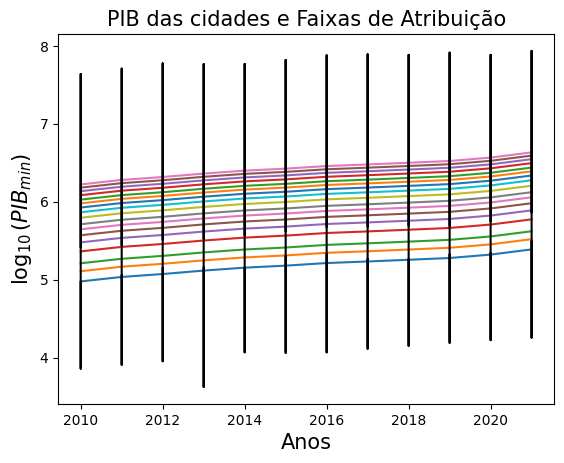

In [ ]:
for j in range(1,18):
    plotar = [tabelas_p1_var[f'{2010+i}']['faixa_1'][j] for i in range(12)]
    plt.plot(range(2010,2022), np.log10(plotar))
for ano in range(2010, 2022):
    plt.plot([ano]*len(pib[f'pib_{ano}']), np.log10(pib[f'pib_{ano}']), color='black')

plt.title('PIB das cidades e Faixas de Atribuição', fontsize=15)
plt.xlabel('Anos', fontsize=15)
plt.ylabel('$\log_{10}(PIB_{min})$', fontsize=15)
plt.show()

In [ ]:
#--------- Atribui Lambda para o método antigo e o novo - MUNICÍPIOS ---------#

def atribuir_lambda_p1_var(valor, i):
    for _, row in tabelas_p1_var[f'{2010 + i}'].iterrows():
        faixa_1 = float(row['faixa_1'])
        faixa_2 = float(row['faixa_2'])
        if faixa_1 <= float(valor) <= faixa_2:
            return float(row['lambda'].replace(",", "."))
    return None


for i in range(0, 12):
    data1[f'p1_var{2010+i}'] =  data1[f'pib_{2010+i}'].apply(lambda x: atribuir_lambda_p1_var(x, i))


<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-548072240.py:3: SyntaxWarning: invalid escape sequence '\l'
  plt.title('Distribuição das cidades por $\lambda$ atribuido', fontsize=15)
/tmp/ipython-input-548072240.py:4: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$', fontsize=15)


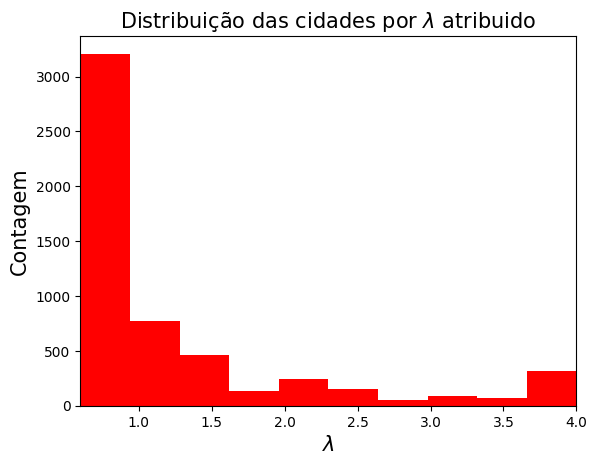

In [ ]:
ano = 2021
plt.hist(data1[f'p1_var{ano}'], color='red')
plt.title('Distribuição das cidades por $\lambda$ atribuido', fontsize=15)
plt.xlabel('$\lambda$', fontsize=15)
plt.ylabel('Contagem', fontsize=15)
plt.xlim(0.6, 4)
plt.show()

<>:23: SyntaxWarning: invalid escape sequence '\l'
<>:25: SyntaxWarning: invalid escape sequence '\s'
<>:23: SyntaxWarning: invalid escape sequence '\l'
<>:25: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-923247502.py:23: SyntaxWarning: invalid escape sequence '\l'
  ax_main.set_title('Distribuição das cidades por $\lambda$ atribuído', fontsize=15)
/tmp/ipython-input-923247502.py:25: SyntaxWarning: invalid escape sequence '\s'
  ax_main.set_ylabel('$\sigma^2$', fontsize=15)
/tmp/ipython-input-923247502.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap('viridis')


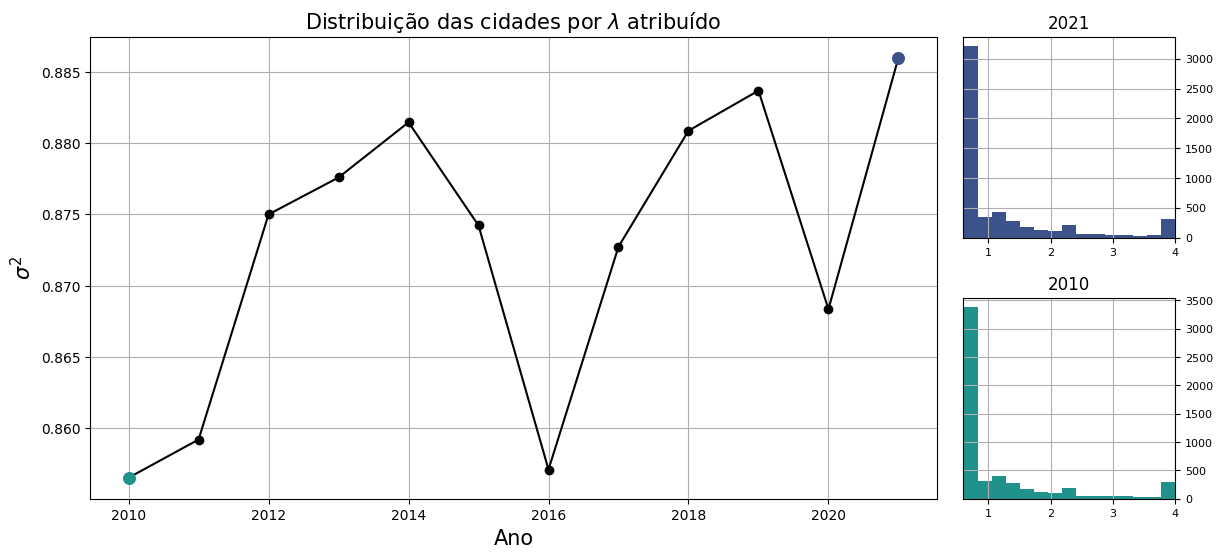

In [ ]:
# Lista de anos
viridis = cm.get_cmap('viridis')

anos = list(range(2010, 2022))

# Variância para cada ano
variancias1 = [data1[f'p1_var{ano}'].var() for ano in anos]

# Cores específicas
cor_inicio = viridis(0.5)  # 2010
cor_fim = viridis(0.25)    # 2021

# Criando figura com GridSpec
fig = plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 1], wspace=0.05, hspace=0.3)  # wspace menor para reduzir espaço

# --- Gráfico principal ---
ax_main = fig.add_subplot(gs[:, 0])
ax_main.plot(anos, variancias1, color = 'black' , marker='o')
ax_main.scatter(anos[0], variancias1[0], color=cor_inicio, s=70, zorder=5)
ax_main.scatter(anos[-1], variancias1[-1], color=cor_fim, s=70, zorder=5)

ax_main.set_title('Distribuição das cidades por $\lambda$ atribuído', fontsize=15)
ax_main.set_xlabel('Ano', fontsize=15)
ax_main.set_ylabel('$\sigma^2$', fontsize=15)
#ax_main.set_ylim(0.85, 0.89)
ax_main.grid(True)

# --- Histograma 2021 em cima ---
ax_hist1 = fig.add_subplot(gs[0, 1])
ano_fim = anos[-1]
ax_hist1.hist(data1[f'p1_var{ano_fim}'], color=cor_fim, bins=15)
ax_hist1.set_xlim(0.6, 4)
ax_hist1.set_title(f'{ano_fim}', fontsize=12)
ax_hist1.tick_params(axis='both', which='major', labelsize=8)
ax_hist1.grid(True)
ax_hist1.yaxis.tick_right()  # Coloca o eixo y na direita
ax_hist1.yaxis.set_label_position("right")  # Label do eixo y na direita também

# --- Histograma 2010 embaixo ---
ax_hist2 = fig.add_subplot(gs[1, 1])
ano_inicio = anos[0]
ax_hist2.hist(data1[f'p1_var{ano_inicio}'], color=cor_inicio, bins=15)
ax_hist2.set_xlim(0.6, 4)
ax_hist2.set_title(f'{ano_inicio}', fontsize=12)
ax_hist2.tick_params(axis='both', which='major', labelsize=8)
ax_hist2.grid(True)
ax_hist2.yaxis.tick_right()  # Coloca o eixo y na direita
ax_hist2.yaxis.set_label_position("right")  # Label do eixo y na direita também

plt.show()


## 3.3 - Tabela variável trianual

In [ ]:
#--------- Encontra novas tabelas (cada ano) para beta fixo e N0 ---------#

anos = range(12)
tabelas_p1_tri = {}

for ano in anos:
    if ano in [0, 3, 6, 9]:
        N0 = N_ev_novo[ano]
    df_pib = pd.DataFrame({
        "faixa_1": np.round(N0 * (faixas_lambdas["faixa_1"] ** beta_fixo), 2),
        "faixa_2": np.round(N0 * (faixas_lambdas["faixa_2"] ** beta_fixo), 2),
        'lambda': faixas_lambdas["lambda"]
    })
    df_pib.loc[1:, "faixa_1"] = df_pib["faixa_2"].shift(1) + 0.01  # Soma de R$0,01
    tabelas_p1_tri[f'{2010+ano}'] = df_pib

<>:9: SyntaxWarning: invalid escape sequence '\l'
<>:9: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-2985476573.py:9: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('$\log_{10}(PIB_{min})$', fontsize=15)


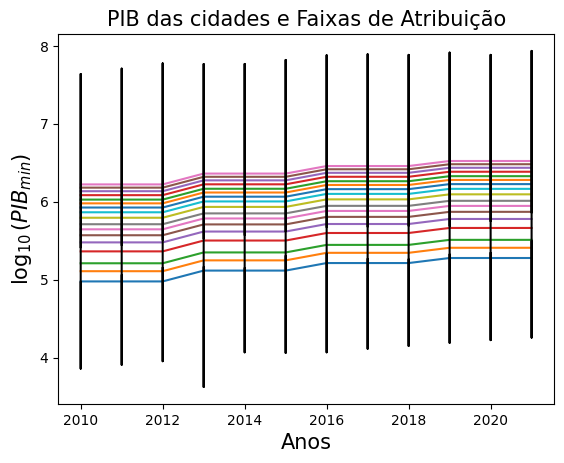

In [ ]:
for j in range(1,18):
    plotar = [tabelas_p1_tri[f'{2010+i}']['faixa_1'][j] for i in range(12)]
    plt.plot(range(2010,2022), np.log10(plotar))
for ano in range(2010, 2022):
    plt.plot([ano]*len(pib[f'pib_{ano}']), np.log10(pib[f'pib_{ano}']), color='black')

plt.title('PIB das cidades e Faixas de Atribuição', fontsize=15)
plt.xlabel('Anos', fontsize=15)
plt.ylabel('$\log_{10}(PIB_{min})$', fontsize=15)
plt.show()

In [ ]:
#--------- Atribui Lambda para o método antigo e o novo - MUNICÍPIOS ---------#

def atribuir_lambda_p1_tri(valor, i):
    for _, row in tabelas_p1_tri[f'{2010 + i}'].iterrows():
        faixa_1 = float(row['faixa_1'])
        faixa_2 = float(row['faixa_2'])
        if faixa_1 <= float(valor) <= faixa_2:
            return float(row['lambda'].replace(",", "."))
    return None


for i in range(0, 12):
    data1[f'p1_tri{2010+i}'] =  data1[f'pib_{2010+i}'].apply(lambda x: atribuir_lambda_p1_tri(x, i))


<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-3733333785.py:3: SyntaxWarning: invalid escape sequence '\l'
  plt.title('Distribuição das cidades por $\lambda$ atribuido', fontsize=15)
/tmp/ipython-input-3733333785.py:4: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$', fontsize=15)


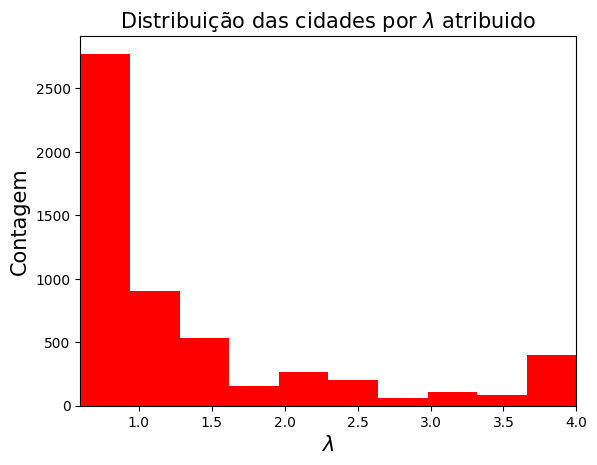

In [ ]:
ano = 2021
plt.hist(data1[f'p1_tri{ano}'], color='red')
plt.title('Distribuição das cidades por $\lambda$ atribuido', fontsize=15)
plt.xlabel('$\lambda$', fontsize=15)
plt.ylabel('Contagem', fontsize=15)
plt.xlim(0.6, 4)
plt.show()

<>:23: SyntaxWarning: invalid escape sequence '\l'
<>:25: SyntaxWarning: invalid escape sequence '\s'
<>:23: SyntaxWarning: invalid escape sequence '\l'
<>:25: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2511454216.py:23: SyntaxWarning: invalid escape sequence '\l'
  ax_main.set_title('Distribuição das cidades por $\lambda$ atribuído', fontsize=15)
/tmp/ipython-input-2511454216.py:25: SyntaxWarning: invalid escape sequence '\s'
  ax_main.set_ylabel('$\sigma^2$', fontsize=15)
/tmp/ipython-input-2511454216.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap('viridis')


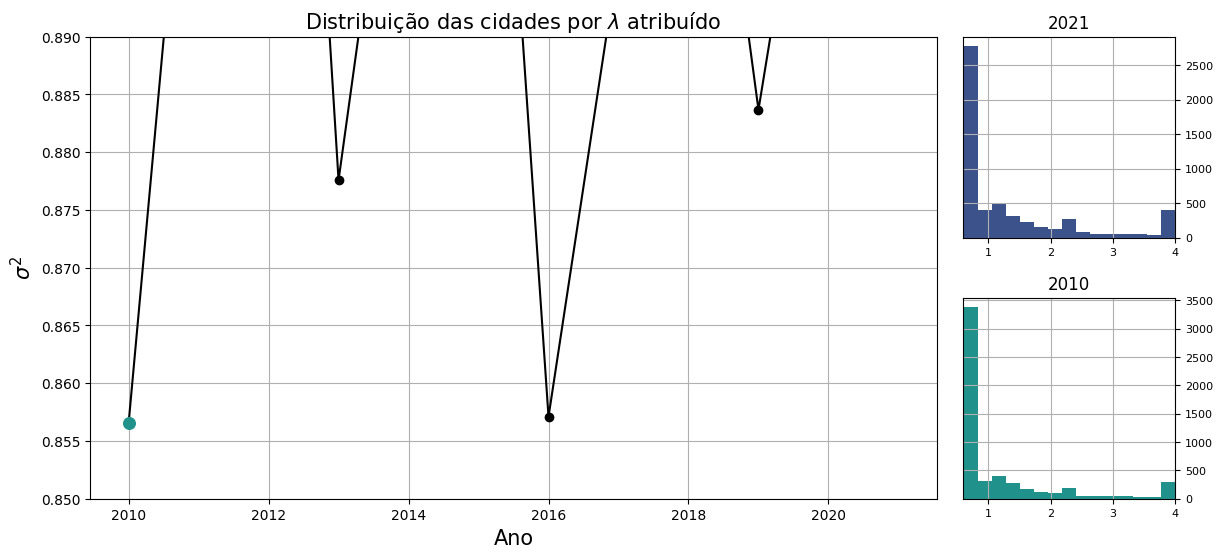

In [ ]:
# Lista de anos
viridis = cm.get_cmap('viridis')

anos = list(range(2010, 2022))

# Variância para cada ano
variancias5 = [data1[f'p1_tri{ano}'].var() for ano in anos]

# Cores específicas
cor_inicio = viridis(0.5)  # 2010
cor_fim = viridis(0.25)    # 2021

# Criando figura com GridSpec
fig = plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 1], wspace=0.05, hspace=0.3)  # wspace menor para reduzir espaço

# --- Gráfico principal ---
ax_main = fig.add_subplot(gs[:, 0])
ax_main.plot(anos, variancias5, color = 'black' , marker='o')
ax_main.scatter(anos[0], variancias5[0], color=cor_inicio, s=70, zorder=5)
ax_main.scatter(anos[-1], variancias5[-1], color=cor_fim, s=70, zorder=5)

ax_main.set_title('Distribuição das cidades por $\lambda$ atribuído', fontsize=15)
ax_main.set_xlabel('Ano', fontsize=15)
ax_main.set_ylabel('$\sigma^2$', fontsize=15)
ax_main.set_ylim(0.85, 0.89)
ax_main.grid(True)

# --- Histograma 2021 em cima ---
ax_hist1 = fig.add_subplot(gs[0, 1])
ano_fim = anos[-1]
ax_hist1.hist(data1[f'p1_tri{ano_fim}'], color=cor_fim, bins=15)
ax_hist1.set_xlim(0.6, 4)
ax_hist1.set_title(f'{ano_fim}', fontsize=12)
ax_hist1.tick_params(axis='both', which='major', labelsize=8)
ax_hist1.grid(True)
ax_hist1.yaxis.tick_right()  # Coloca o eixo y na direita
ax_hist1.yaxis.set_label_position("right")  # Label do eixo y na direita também

# --- Histograma 2010 embaixo ---
ax_hist2 = fig.add_subplot(gs[1, 1])
ano_inicio = anos[0]
ax_hist2.hist(data1[f'p1_tri{ano_inicio}'], color=cor_inicio, bins=15)
ax_hist2.set_xlim(0.6, 4)
ax_hist2.set_title(f'{ano_inicio}', fontsize=12)
ax_hist2.tick_params(axis='both', which='major', labelsize=8)
ax_hist2.grid(True)
ax_hist2.yaxis.tick_right()  # Coloca o eixo y na direita
ax_hist2.yaxis.set_label_position("right")  # Label do eixo y na direita também

plt.show()


# 3 - Proposta 2: PIB como critério, mas construindo a Tabela baseada no máximo e mínimo do PIB
A proposta atual é semelhante a anterior. Porém, como vimos que há uma quantidade significativa de cidades longe dos limites das faixas, vamos redefinir usando o valor R$ 0,00 como inicial e dividindo o resto em um total de 18 partes finalizando no maior PIB. No caso ta Tabela Fixa, teremos que adaptar a o valor máximo da última faixa para incluir o valor dos outros anos também, não excluindo do intervalo de recebimento.

## 3.1 - Tabela Fixa

In [ ]:
#--------- Encontra novas tabelas nova divisão maximo e minimo fixo ---------#

limites = np.linspace(0, max(pib['pib_2010']), 19)

tabelas_p2_fixa = pd.DataFrame({
    'faixa_1': np.round(limites[:-1], 2),
    'faixa_2': np.round(limites[1:], 2),    # do segundo até o último
    'lambda': faixas_lambdas["lambda"]
})

tabelas_p2_fixa.loc[1:, "faixa_1"] = tabelas_p2_fixa["faixa_2"].shift(1) + 0.01  # Soma de R$0,01

tabelas_p2_fixa.loc[17, 'faixa_2'] = 10**10 # Necessário para não dar problema para os próximos anos

In [ ]:
tabelas_p2_fixa

,faixa_1,faixa_2,lambda
0,0.00,2.416655e+06,"0,6"
1,2416654.73,4.833309e+06,"0,8"
2,4833309.45,7.249964e+06,1
3,7249964.18,9.666619e+06,"1,2"
4,9666618.90,1.208327e+07,"1,4"
5,12083273.62,1.449993e+07,"1,6"
6,14499928.34,1.691658e+07,"1,8"
7,16916583.07,1.933324e+07,2
8,19333237.79,2.174989e+07,"2,2"
9,21749892.51,2.416655e+07,"2,4"


<>:9: SyntaxWarning: invalid escape sequence '\l'
<>:9: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-431897142.py:9: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('$\log_{10}$(Faixa 1)', fontsize=15)


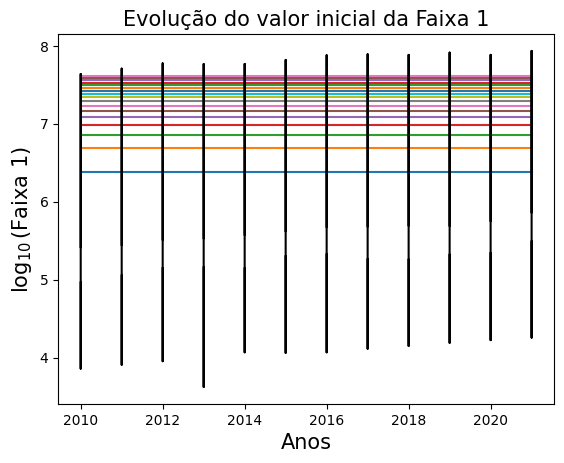

In [ ]:
for j in range(1,18):
    plotar = [tabelas_p2_fixa['faixa_1'][j] for i in range(12)]
    plt.plot(range(2010,2022), np.log10(plotar))
for ano in range(2010, 2022):
    plt.plot([ano]*len(pib[f'pib_{ano}']), np.log10(pib[f'pib_{ano}']), color='black')

plt.title('Evolução do valor inicial da Faixa 1', fontsize=15)
plt.xlabel('Anos', fontsize=15)
plt.ylabel('$\log_{10}$(Faixa 1)', fontsize=15)
#plt.grid()
plt.show()

In [ ]:
#--------- Atribui Lambda ---------#

def atribuir_lambda_p2_fixo(valor):
    for _, row in tabelas_p2_fixa.iterrows():
        faixa_1 = float(row['faixa_1'])
        faixa_2 = float(row['faixa_2'])
        if faixa_1 <= float(valor) <= faixa_2:
            return float(row['lambda'].replace(",", "."))
    return None

for i in range(0, 12):
    data1[f'p2_fixo{2010+i}'] =  data1[f'pib_{2010+i}'].apply(lambda x: atribuir_lambda_p2_fixo(x))


<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-493309868.py:3: SyntaxWarning: invalid escape sequence '\l'
  plt.title('Distribuição das cidades por $\lambda$ atribuido', fontsize=15)
/tmp/ipython-input-493309868.py:4: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$', fontsize=15)


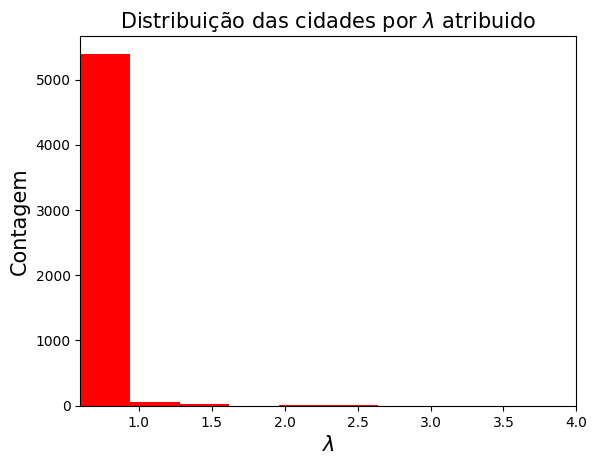

In [ ]:
ano = 2010
plt.hist(data1[f'p2_fixo{ano}'], color='red')
plt.title('Distribuição das cidades por $\lambda$ atribuido', fontsize=15)
plt.xlabel('$\lambda$', fontsize=15)
plt.ylabel('Contagem', fontsize=15)
plt.xlim(0.6, 4)
plt.show()

<>:23: SyntaxWarning: invalid escape sequence '\l'
<>:25: SyntaxWarning: invalid escape sequence '\s'
<>:23: SyntaxWarning: invalid escape sequence '\l'
<>:25: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-2546443717.py:23: SyntaxWarning: invalid escape sequence '\l'
  ax_main.set_title('Distribuição das cidades por $\lambda$ atribuído', fontsize=15)
/tmp/ipython-input-2546443717.py:25: SyntaxWarning: invalid escape sequence '\s'
  ax_main.set_ylabel('$\sigma^2$', fontsize=15)
/tmp/ipython-input-2546443717.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap('viridis')


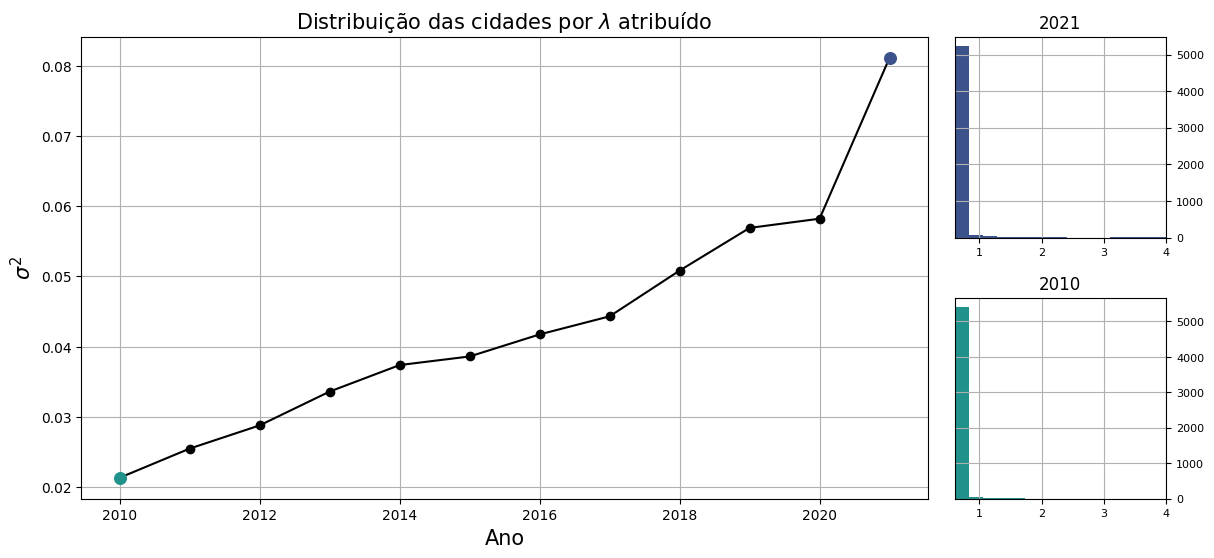

In [ ]:
# Lista de anos
viridis = cm.get_cmap('viridis')

anos = list(range(2010, 2022))

# Variância para cada ano
variancias2 = [data1[f'p2_fixo{ano}'].var() for ano in anos]

# Cores específicas
cor_inicio = viridis(0.5)  # 2010
cor_fim = viridis(0.25)    # 2021

# Criando figura com GridSpec
fig = plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 1], wspace=0.05, hspace=0.3)  # wspace menor para reduzir espaço

# --- Gráfico principal ---
ax_main = fig.add_subplot(gs[:, 0])
ax_main.plot(anos, variancias2, color = 'black' , marker='o')
ax_main.scatter(anos[0], variancias2[0], color=cor_inicio, s=70, zorder=5)
ax_main.scatter(anos[-1], variancias2[-1], color=cor_fim, s=70, zorder=5)

ax_main.set_title('Distribuição das cidades por $\lambda$ atribuído', fontsize=15)
ax_main.set_xlabel('Ano', fontsize=15)
ax_main.set_ylabel('$\sigma^2$', fontsize=15)
#ax_main.set_ylim(0.85, 0.89)
ax_main.grid(True)

# --- Histograma 2021 em cima ---
ax_hist1 = fig.add_subplot(gs[0, 1])
ano_fim = anos[-1]
ax_hist1.hist(data1[f'p2_fixo{ano_fim}'], color=cor_fim, bins=15)
ax_hist1.set_xlim(0.6, 4)
ax_hist1.set_title(f'{ano_fim}', fontsize=12)
ax_hist1.tick_params(axis='both', which='major', labelsize=8)
ax_hist1.grid(True)
ax_hist1.yaxis.tick_right()  # Coloca o eixo y na direita
ax_hist1.yaxis.set_label_position("right")  # Label do eixo y na direita também

# --- Histograma 2010 embaixo ---
ax_hist2 = fig.add_subplot(gs[1, 1])
ano_inicio = anos[0]
ax_hist2.hist(data1[f'p2_fixo{ano_inicio}'], color=cor_inicio, bins=15)
ax_hist2.set_xlim(0.6, 4)
ax_hist2.set_title(f'{ano_inicio}', fontsize=12)
ax_hist2.tick_params(axis='both', which='major', labelsize=8)
ax_hist2.grid(True)
ax_hist2.yaxis.tick_right()  # Coloca o eixo y na direita
ax_hist2.yaxis.set_label_position("right")  # Label do eixo y na direita também

plt.show()


## 3.2 - Tabela Variável


In [ ]:
#--------- Encontra novas tabelas nova divisão maximo e minimo fixo variando ---------#

anos = range(12)

tabelas_p2_var = {}

for ano in anos:
    limites = np.linspace(0, max(pib[f'pib_{2010+ano}']), 19)
    df_max = pd.DataFrame({
        "faixa_1": np.round(limites[:-1], 2),
        "faixa_2": np.round(limites[1:], 2),
        'lambda': faixas_lambdas["lambda"]
    })
    df_max.loc[1:, "faixa_1"] = df_max["faixa_2"].shift(1) + 0.01  # Soma de R$0,01

    tabelas_p2_var[f'{2010+ano}'] = df_max

In [ ]:
tabelas_p2_var['2010']

,faixa_1,faixa_2,lambda
0,0.00,2416654.72,"0,6"
1,2416654.73,4833309.44,"0,8"
2,4833309.45,7249964.17,1
3,7249964.18,9666618.89,"1,2"
4,9666618.90,12083273.61,"1,4"
5,12083273.62,14499928.33,"1,6"
6,14499928.34,16916583.06,"1,8"
7,16916583.07,19333237.78,2
8,19333237.79,21749892.50,"2,2"
9,21749892.51,24166547.22,"2,4"


<>:9: SyntaxWarning: invalid escape sequence '\l'
<>:9: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-933526525.py:9: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('$\log_{10}$(Faixa 1)', fontsize=15)


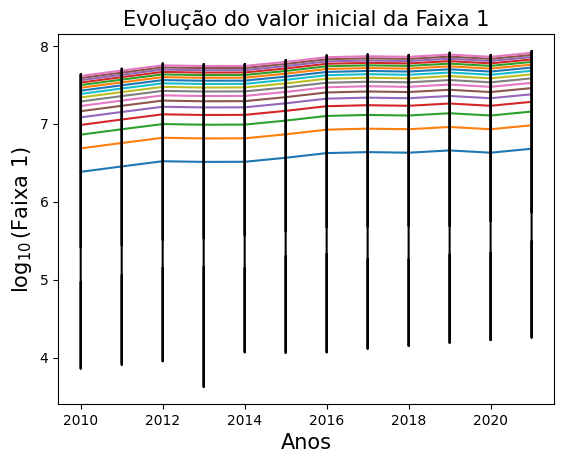

In [ ]:
for j in range(1,18):
    plotar = [tabelas_p2_var[f'{2010+i}']['faixa_1'][j] for i in range(12)]
    plt.plot(range(2010,2022), np.log10(plotar))
for ano in range(2010, 2022):
    plt.plot([ano]*len(pib[f'pib_{ano}']), np.log10(pib[f'pib_{ano}']), color='black')

plt.title('Evolução do valor inicial da Faixa 1', fontsize=15)
plt.xlabel('Anos', fontsize=15)
plt.ylabel('$\log_{10}$(Faixa 1)', fontsize=15)
#plt.grid()
plt.show()

In [ ]:
def atribuir_lambda_p2_var(valor, i):
    for _, row in tabelas_p2_var[f'{2010 + i}'].iterrows():
        faixa_1 = float(row['faixa_1'])
        faixa_2 = float(row['faixa_2'])
        if faixa_1 <= float(valor) <= faixa_2:
            return float(row['lambda'].replace(",", "."))
    return None

for i in range(0, 12):
    data1[f'p2_var{2010+i}'] =  data1[f'pib_{2010+i}'].apply(lambda x: atribuir_lambda_p2_var(x, i))

<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-723438201.py:3: SyntaxWarning: invalid escape sequence '\l'
  plt.title('Distribuição das cidades por $\lambda$ atribuido', fontsize=15)
/tmp/ipython-input-723438201.py:4: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$', fontsize=15)


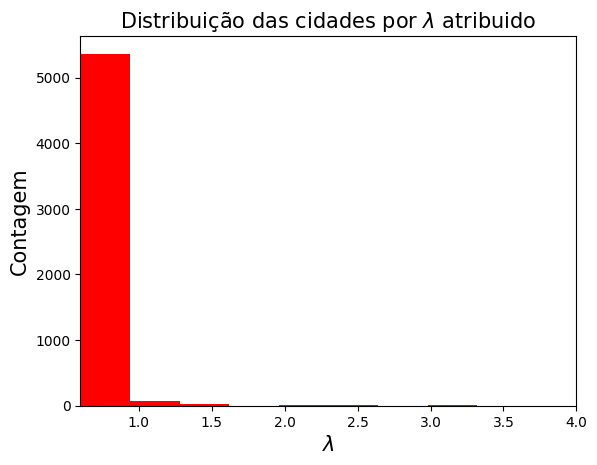

In [ ]:
ano = 2021
plt.hist(data1[f'p2_var{ano}'], color='red')
plt.title('Distribuição das cidades por $\lambda$ atribuido', fontsize=15)
plt.xlabel('$\lambda$', fontsize=15)
plt.ylabel('Contagem', fontsize=15)
plt.xlim(0.6, 4)
plt.show()

<>:23: SyntaxWarning: invalid escape sequence '\l'
<>:25: SyntaxWarning: invalid escape sequence '\s'
<>:23: SyntaxWarning: invalid escape sequence '\l'
<>:25: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-3844029752.py:23: SyntaxWarning: invalid escape sequence '\l'
  ax_main.set_title('Distribuição das cidades por $\lambda$ atribuído', fontsize=15)
/tmp/ipython-input-3844029752.py:25: SyntaxWarning: invalid escape sequence '\s'
  ax_main.set_ylabel('$\sigma^2$', fontsize=15)
/tmp/ipython-input-3844029752.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap('viridis')


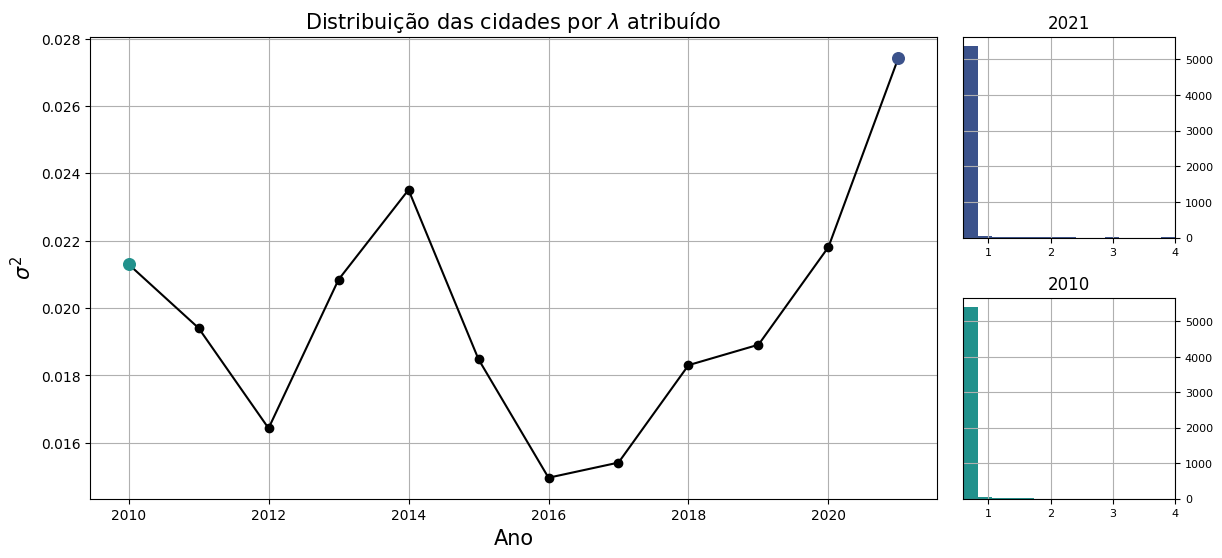

In [ ]:
# Lista de anos
viridis = cm.get_cmap('viridis')

anos = list(range(2010, 2022))

# Variância para cada ano
variancias3 = [data1[f'p2_var{ano}'].var() for ano in anos]

# Cores específicas
cor_inicio = viridis(0.5)  # 2010
cor_fim = viridis(0.25)    # 2021

# Criando figura com GridSpec
fig = plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 1], wspace=0.05, hspace=0.3)  # wspace menor para reduzir espaço

# --- Gráfico principal ---
ax_main = fig.add_subplot(gs[:, 0])
ax_main.plot(anos, variancias3, color = 'black' , marker='o')
ax_main.scatter(anos[0], variancias3[0], color=cor_inicio, s=70, zorder=5)
ax_main.scatter(anos[-1], variancias3[-1], color=cor_fim, s=70, zorder=5)

ax_main.set_title('Distribuição das cidades por $\lambda$ atribuído', fontsize=15)
ax_main.set_xlabel('Ano', fontsize=15)
ax_main.set_ylabel('$\sigma^2$', fontsize=15)
#ax_main.set_ylim(0.85, 0.89)
ax_main.grid(True)

# --- Histograma 2021 em cima ---
ax_hist1 = fig.add_subplot(gs[0, 1])
ano_fim = anos[-1]
ax_hist1.hist(data1[f'p2_var{ano_fim}'], color=cor_fim, bins=15)
ax_hist1.set_xlim(0.6, 4)
ax_hist1.set_title(f'{ano_fim}', fontsize=12)
ax_hist1.tick_params(axis='both', which='major', labelsize=8)
ax_hist1.grid(True)
ax_hist1.yaxis.tick_right()  # Coloca o eixo y na direita
ax_hist1.yaxis.set_label_position("right")  # Label do eixo y na direita também

# --- Histograma 2010 embaixo ---
ax_hist2 = fig.add_subplot(gs[1, 1])
ano_inicio = anos[0]
ax_hist2.hist(data1[f'p2_var{ano_inicio}'], color=cor_inicio, bins=15)
ax_hist2.set_xlim(0.6, 4)
ax_hist2.set_title(f'{ano_inicio}', fontsize=12)
ax_hist2.tick_params(axis='both', which='major', labelsize=8)
ax_hist2.grid(True)
ax_hist2.yaxis.tick_right()  # Coloca o eixo y na direita
ax_hist2.yaxis.set_label_position("right")  # Label do eixo y na direita também

plt.show()


## 3.3 - Tabela Variável trianual


In [ ]:
#--------- Encontra novas tabelas nova divisão maximo e minimo fixo variando ---------#

anos = range(12)

tabelas_p2_tri = {}

for ano in anos:
    if ano in [0, 3, 6, 9]:
        limites = np.linspace(0, max(pib[f'pib_{2010+ano}']), 19)
    df_max = pd.DataFrame({
        "faixa_1": np.round(limites[:-1], 2),
        "faixa_2": np.round(limites[1:], 2),
        'lambda': faixas_lambdas["lambda"]
    })
    df_max.loc[1:, "faixa_1"] = df_max["faixa_2"].shift(1) + 0.01  # Soma de R$0,01

    tabelas_p2_tri[f'{2010+ano}'] = df_max

<>:9: SyntaxWarning: invalid escape sequence '\l'
<>:9: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-3312447339.py:9: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('$\log_{10}$(Faixa 1)', fontsize=15)


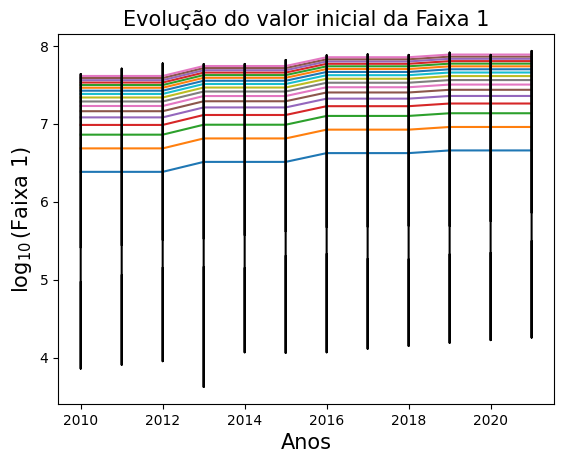

In [ ]:
for j in range(1,18):
    plotar = [tabelas_p2_tri[f'{2010+i}']['faixa_1'][j] for i in range(12)]
    plt.plot(range(2010,2022), np.log10(plotar))
for ano in range(2010, 2022):
    plt.plot([ano]*len(pib[f'pib_{ano}']), np.log10(pib[f'pib_{ano}']), color='black')

plt.title('Evolução do valor inicial da Faixa 1', fontsize=15)
plt.xlabel('Anos', fontsize=15)
plt.ylabel('$\log_{10}$(Faixa 1)', fontsize=15)
#plt.grid()
plt.show()

In [ ]:
def atribuir_lambda_p2_tri(valor, i):
    for _, row in tabelas_p2_tri[f'{2010 + i}'].iterrows():
        faixa_1 = float(row['faixa_1'])
        faixa_2 = float(row['faixa_2'])
        if faixa_1 <= float(valor) <= faixa_2:
            return float(row['lambda'].replace(",", "."))
    return None

for i in range(0, 12):
    data1[f'p2_tri{2010+i}'] =  data1[f'pib_{2010+i}'].apply(lambda x: atribuir_lambda_p2_tri(x, i))

<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-2686284182.py:3: SyntaxWarning: invalid escape sequence '\l'
  plt.title('Distribuição das cidades por $\lambda$ atribuido', fontsize=15)
/tmp/ipython-input-2686284182.py:4: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$', fontsize=15)


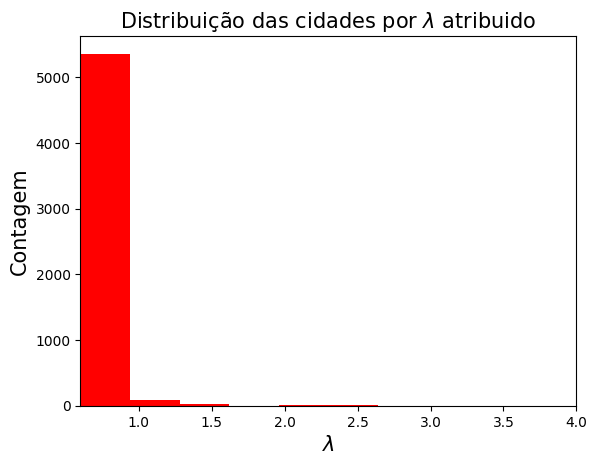

In [ ]:
ano = 2021
plt.hist(data1[f'p2_tri{ano}'], color='red')
plt.title('Distribuição das cidades por $\lambda$ atribuido', fontsize=15)
plt.xlabel('$\lambda$', fontsize=15)
plt.ylabel('Contagem', fontsize=15)
plt.xlim(0.6, 4)
plt.show()

<>:23: SyntaxWarning: invalid escape sequence '\l'
<>:25: SyntaxWarning: invalid escape sequence '\s'
<>:23: SyntaxWarning: invalid escape sequence '\l'
<>:25: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-1813147778.py:23: SyntaxWarning: invalid escape sequence '\l'
  ax_main.set_title('Distribuição das cidades por $\lambda$ atribuído', fontsize=15)
/tmp/ipython-input-1813147778.py:25: SyntaxWarning: invalid escape sequence '\s'
  ax_main.set_ylabel('$\sigma^2$', fontsize=15)
/tmp/ipython-input-1813147778.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap('viridis')


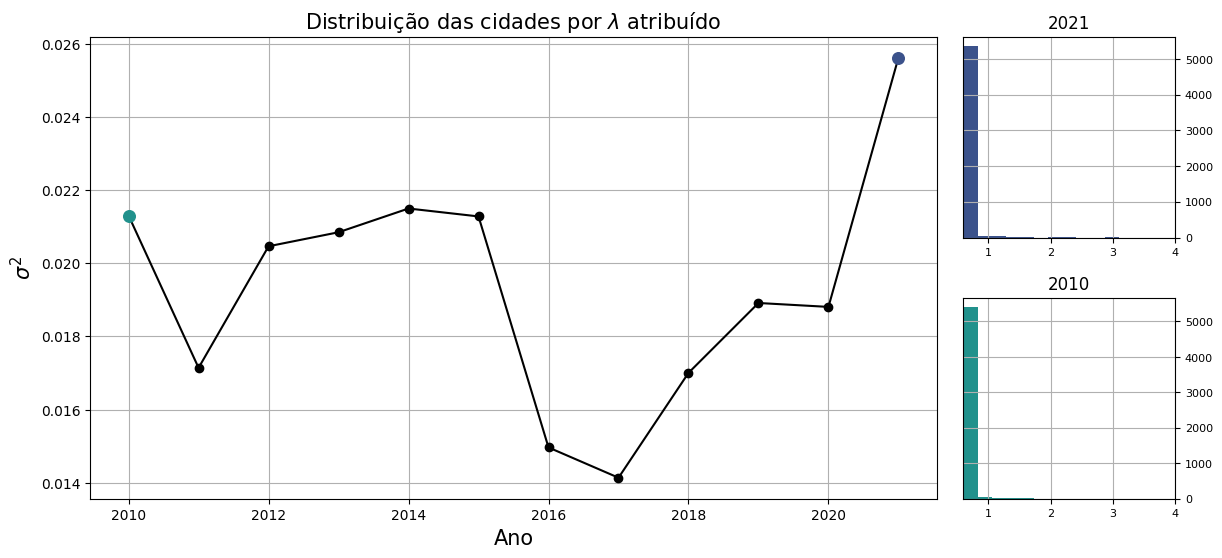

In [ ]:
# Lista de anos
viridis = cm.get_cmap('viridis')

anos = list(range(2010, 2022))

# Variância para cada ano
variancias6 = [data1[f'p2_tri{ano}'].var() for ano in anos]

# Cores específicas
cor_inicio = viridis(0.5)  # 2010
cor_fim = viridis(0.25)    # 2021

# Criando figura com GridSpec
fig = plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 1], wspace=0.05, hspace=0.3)  # wspace menor para reduzir espaço

# --- Gráfico principal ---
ax_main = fig.add_subplot(gs[:, 0])
ax_main.plot(anos, variancias6, color = 'black' , marker='o')
ax_main.scatter(anos[0], variancias6[0], color=cor_inicio, s=70, zorder=5)
ax_main.scatter(anos[-1], variancias6[-1], color=cor_fim, s=70, zorder=5)

ax_main.set_title('Distribuição das cidades por $\lambda$ atribuído', fontsize=15)
ax_main.set_xlabel('Ano', fontsize=15)
ax_main.set_ylabel('$\sigma^2$', fontsize=15)
#ax_main.set_ylim(0.85, 0.89)
ax_main.grid(True)

# --- Histograma 2021 em cima ---
ax_hist1 = fig.add_subplot(gs[0, 1])
ano_fim = anos[-1]
ax_hist1.hist(data1[f'p2_tri{ano_fim}'], color=cor_fim, bins=15)
ax_hist1.set_xlim(0.6, 4)
ax_hist1.set_title(f'{ano_fim}', fontsize=12)
ax_hist1.tick_params(axis='both', which='major', labelsize=8)
ax_hist1.grid(True)
ax_hist1.yaxis.tick_right()  # Coloca o eixo y na direita
ax_hist1.yaxis.set_label_position("right")  # Label do eixo y na direita também

# --- Histograma 2010 embaixo ---
ax_hist2 = fig.add_subplot(gs[1, 1])
ano_inicio = anos[0]
ax_hist2.hist(data1[f'p2_tri{ano_inicio}'], color=cor_inicio, bins=15)
ax_hist2.set_xlim(0.6, 4)
ax_hist2.set_title(f'{ano_inicio}', fontsize=12)
ax_hist2.tick_params(axis='both', which='major', labelsize=8)
ax_hist2.grid(True)
ax_hist2.yaxis.tick_right()  # Coloca o eixo y na direita
ax_hist2.yaxis.set_label_position("right")  # Label do eixo y na direita também

plt.show()


# 4 - Método Atual: População como critério
O método atual utiliza da *População* para fazer tal medida. Vamos fazer a mesma análise que fizemos para os métodos propostos, só que para o já utilizado.

<>:8: SyntaxWarning: invalid escape sequence '\l'
<>:8: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-2372463021.py:8: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('$\log_{10}$(Faixa 1)', fontsize=15)


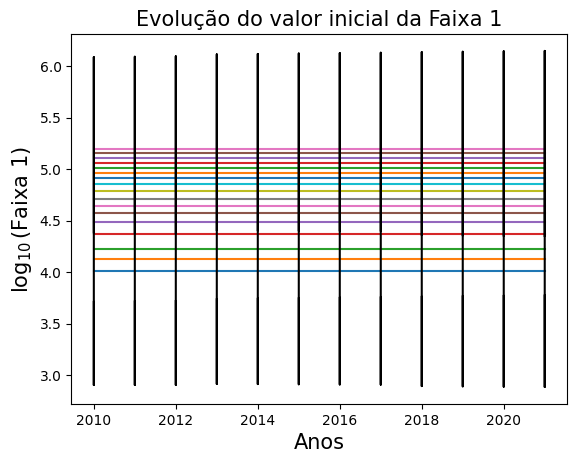

In [ ]:
for j in range(1,18):
    plotar = [faixas_lambdas['faixa_1'][j] for i in range(12)]
    plt.plot(range(2010,2022), np.log10(plotar))
for ano in range(2010, 2022):
    plt.plot([ano]*len(pop[f'pop_{ano}']), np.log10(pop[f'pop_{ano}']), color='black')
plt.title('Evolução do valor inicial da Faixa 1', fontsize=15)
plt.xlabel('Anos', fontsize=15)
plt.ylabel('$\log_{10}$(Faixa 1)', fontsize=15)
#plt.grid()
plt.show()

In [ ]:
def atribuir_lambda_atual(valor):
    for _, row in faixas_lambdas.iterrows():
        faixa_1 = float(row['faixa_1'])
        faixa_2 = float(row['faixa_2'])
        if faixa_1 <= float(valor) <= faixa_2:
            return float(row['lambda'].replace(",", "."))
    return None

for i in range(0, 12):
    data1[f'atual{2010+i}'] =  data1[f'populacao_{2010+i}'].apply(lambda x: atribuir_lambda_atual(x))

<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
<>:3: SyntaxWarning: invalid escape sequence '\l'
<>:4: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-2330103063.py:3: SyntaxWarning: invalid escape sequence '\l'
  plt.title('Distribuição das cidades por $\lambda$ atribuido', fontsize=15)
/tmp/ipython-input-2330103063.py:4: SyntaxWarning: invalid escape sequence '\l'
  plt.xlabel('$\lambda$', fontsize=15)


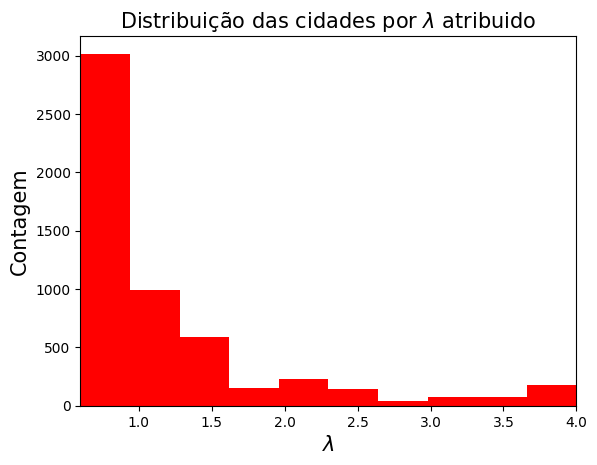

In [ ]:
ano = 2021
plt.hist(data1[f'atual{ano}'], color='red')
plt.title('Distribuição das cidades por $\lambda$ atribuido', fontsize=15)
plt.xlabel('$\lambda$', fontsize=15)
plt.ylabel('Contagem', fontsize=15)
plt.xlim(0.6, 4)
plt.show()

<>:23: SyntaxWarning: invalid escape sequence '\l'
<>:25: SyntaxWarning: invalid escape sequence '\s'
<>:23: SyntaxWarning: invalid escape sequence '\l'
<>:25: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-351974076.py:23: SyntaxWarning: invalid escape sequence '\l'
  ax_main.set_title('Distribuição das cidades por $\lambda$ atribuído', fontsize=15)
/tmp/ipython-input-351974076.py:25: SyntaxWarning: invalid escape sequence '\s'
  ax_main.set_ylabel('$\sigma^2$', fontsize=15)
/tmp/ipython-input-351974076.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = cm.get_cmap('viridis')


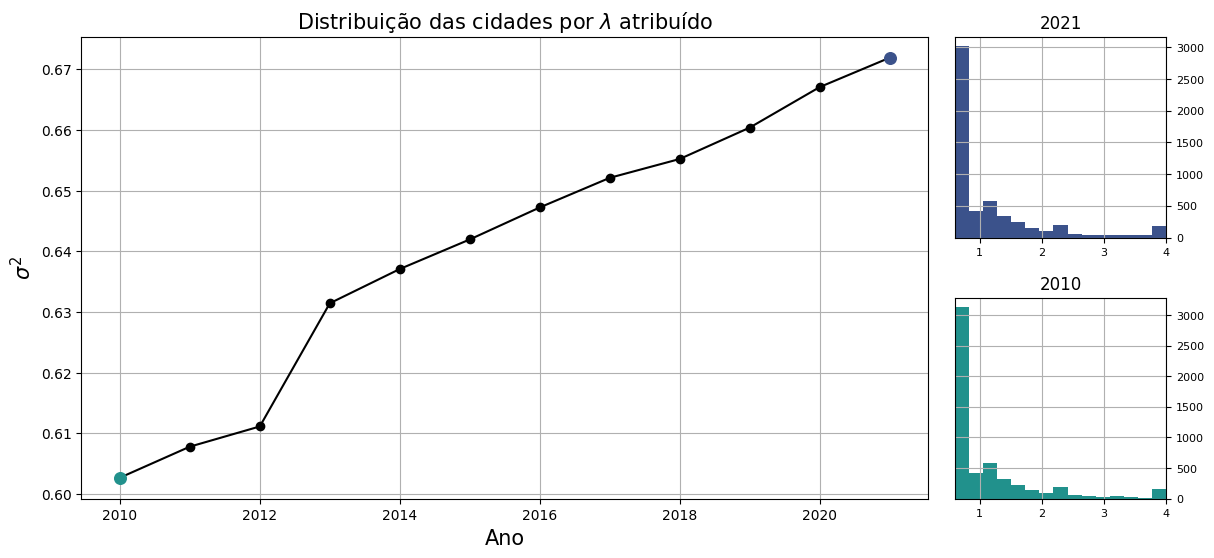

In [ ]:
# Lista de anos
viridis = cm.get_cmap('viridis')

anos = list(range(2010, 2022))

# Variância para cada ano
variancias4 = [data1[f'atual{ano}'].var() for ano in anos]

# Cores específicas
cor_inicio = viridis(0.5)  # 2010
cor_fim = viridis(0.25)    # 2021

# Criando figura com GridSpec
fig = plt.figure(figsize=(14, 6))
gs = gridspec.GridSpec(2, 2, width_ratios=[4, 1], height_ratios=[1, 1], wspace=0.05, hspace=0.3)  # wspace menor para reduzir espaço

# --- Gráfico principal ---
ax_main = fig.add_subplot(gs[:, 0])
ax_main.plot(anos, variancias4, color = 'black' , marker='o')
ax_main.scatter(anos[0], variancias4[0], color=cor_inicio, s=70, zorder=5)
ax_main.scatter(anos[-1], variancias4[-1], color=cor_fim, s=70, zorder=5)

ax_main.set_title('Distribuição das cidades por $\lambda$ atribuído', fontsize=15)
ax_main.set_xlabel('Ano', fontsize=15)
ax_main.set_ylabel('$\sigma^2$', fontsize=15)
#ax_main.set_ylim(0.85, 0.89)
ax_main.grid(True)

# --- Histograma 2021 em cima ---
ax_hist1 = fig.add_subplot(gs[0, 1])
ano_fim = anos[-1]
ax_hist1.hist(data1[f'atual{ano_fim}'], color=cor_fim, bins=15)
ax_hist1.set_xlim(0.6, 4)
ax_hist1.set_title(f'{ano_fim}', fontsize=12)
ax_hist1.tick_params(axis='both', which='major', labelsize=8)
ax_hist1.grid(True)
ax_hist1.yaxis.tick_right()  # Coloca o eixo y na direita
ax_hist1.yaxis.set_label_position("right")  # Label do eixo y na direita também

# --- Histograma 2010 embaixo ---
ax_hist2 = fig.add_subplot(gs[1, 1])
ano_inicio = anos[0]
ax_hist2.hist(data1[f'atual{ano_inicio}'], color=cor_inicio, bins=15)
ax_hist2.set_xlim(0.6, 4)
ax_hist2.set_title(f'{ano_inicio}', fontsize=12)
ax_hist2.tick_params(axis='both', which='major', labelsize=8)
ax_hist2.grid(True)
ax_hist2.yaxis.tick_right()  # Coloca o eixo y na direita
ax_hist2.yaxis.set_label_position("right")  # Label do eixo y na direita também

plt.show()


Vamos comparar todos os resultados agora

<>:11: SyntaxWarning: invalid escape sequence '\l'
<>:12: SyntaxWarning: invalid escape sequence '\l'
<>:11: SyntaxWarning: invalid escape sequence '\l'
<>:12: SyntaxWarning: invalid escape sequence '\l'
/tmp/ipython-input-3115130561.py:11: SyntaxWarning: invalid escape sequence '\l'
  plt.title('Distribuição das cidades por $\lambda$ atribuído', fontsize=15)
/tmp/ipython-input-3115130561.py:12: SyntaxWarning: invalid escape sequence '\l'
  plt.ylabel('$\log_{10}(\sigma^{2})$', fontsize=15)


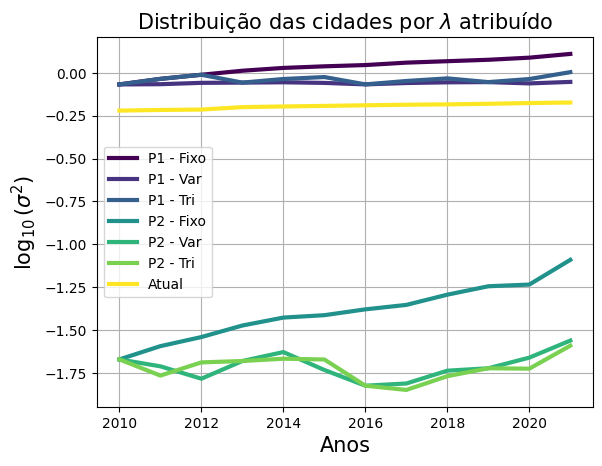

In [ ]:
anos = list(range(2010, 2022))

plt.plot(anos, np.log10(variancias0), lw=3, color = viridis(0.0), label ='P1 - Fixo')
plt.plot(anos, np.log10(variancias1), lw=3,color = viridis(0.15), label ='P1 - Var')
plt.plot(anos, np.log10(variancias5), lw=3,color = viridis(0.30), label ='P1 - Tri')
plt.plot(anos, np.log10(variancias2), lw=3,color = viridis(0.5), label ='P2 - Fixo')
plt.plot(anos, np.log10(variancias3), lw=3,color = viridis(0.65), label ='P2 - Var')
plt.plot(anos, np.log10(variancias6), lw=3,color = viridis(0.80), label ='P2 - Tri')
plt.plot(anos, np.log10(variancias4), lw=3,color = viridis(1.0), label ='Atual')

plt.title('Distribuição das cidades por $\lambda$ atribuído', fontsize=15)
plt.ylabel('$\log_{10}(\sigma^{2})$', fontsize=15)
plt.xlabel('Anos', fontsize=15)
plt.legend()
plt.grid()
plt.show()


# 5 - Forma de distribuição e desigualdade na distribuição

Vimos que temos diferentes formas de distribuir o *FPM*. Agora, vamos verificar como cada método impacta na desiguldade na distribuição do valor.

In [ ]:
#--------- Atribui Lambda para o método atual e o novo - ESTADO ---------#

anos = range(2010, 2022)  # De 2010 a 2021

sum_lambda_p1_fixa = {ano: data1.groupby('uf')[f'p1_fixa{ano}'].sum() for ano in anos}
sum_lambda_p1_var = {ano: data1.groupby('uf')[f'p1_var{ano}'].sum() for ano in anos}
sum_lambda_p1_tri = {ano: data1.groupby('uf')[f'p1_tri{ano}'].sum() for ano in anos}
sum_lambda_p2_fixa = {ano: data1.groupby('uf')[f'p2_fixo{ano}'].sum() for ano in anos}
sum_lambda_p2_var = {ano: data1.groupby('uf')[f'p2_var{ano}'].sum() for ano in anos}
sum_lambda_p2_tri = {ano: data1.groupby('uf')[f'p2_tri{ano}'].sum() for ano in anos}
sum_lambda_atual = {ano: data1.groupby('uf')[f'atual{ano}'].sum() for ano in anos}

for ano in anos:
    data1[f'sum_lambda_p1_fixa{ano}'] = data1['uf'].map(sum_lambda_p1_fixa[ano])
    data1[f'sum_lambda_p1_var{ano}'] = data1['uf'].map(sum_lambda_p1_var[ano])
    data1[f'sum_lambda_p1_tri{ano}'] = data1['uf'].map(sum_lambda_p1_tri[ano])
    data1[f'sum_lambda_p2_fixa{ano}'] = data1['uf'].map(sum_lambda_p2_fixa[ano])
    data1[f'sum_lambda_p2_var{ano}'] = data1['uf'].map(sum_lambda_p2_var[ano])
    data1[f'sum_lambda_p2_tri{ano}'] = data1['uf'].map(sum_lambda_p2_tri[ano])
    data1[f'sum_lambda_atual{ano}'] = data1['uf'].map(sum_lambda_atual[ano])

#---------- Calcular FPM ----------#

for ano in anos:
    data1[f'FPM_p1_fixo{ano}'] = np.round((montante * 0.86 * eta * data1[f'p1_fixa{ano}']) / data1[f'sum_lambda_p1_fixa{ano}'], 2)
    data1[f'FPM_p1_var{ano}'] = np.round((montante * 0.86 * eta * data1[f'p1_var{ano}']) / data1[f'sum_lambda_p1_var{ano}'], 2)
    data1[f'FPM_p1_tri{ano}'] = np.round((montante * 0.86 * eta * data1[f'p1_tri{ano}']) / data1[f'sum_lambda_p1_tri{ano}'], 2)
    data1[f'FPM_p2_fixo{ano}'] = np.round((montante * 0.86 * eta * data1[f'p2_fixo{ano}']) / data1[f'sum_lambda_p2_fixa{ano}'], 2)
    data1[f'FPM_p2_var{ano}'] = np.round((montante * 0.86 * eta * data1[f'p2_var{ano}']) / data1[f'sum_lambda_p2_var{ano}'], 2)
    data1[f'FPM_p2_tri{ano}'] = np.round((montante * 0.86 * eta * data1[f'p2_tri{ano}']) / data1[f'sum_lambda_p2_tri{ano}'], 2)
    data1[f'FPM_atual{ano}'] = (montante * 0.86 * eta * data1[f'atual{ano}']) / data1[f'sum_lambda_atual{ano}']

/tmp/ipython-input-1466651602.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data1[f'sum_lambda_p2_var{ano}'] = data1['uf'].map(sum_lambda_p2_var[ano])
/tmp/ipython-input-1466651602.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data1[f'sum_lambda_p2_tri{ano}'] = data1['uf'].map(sum_lambda_p2_tri[ano])
/tmp/ipython-input-1466651602.py:20: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at on

In [ ]:
gin_list={'p1_fixo': [],
          'p1_var': [],
          'p1_tri': [],
          'p2_fixo': [],
          'p2_var': [],
          'p2_tri': [],
          'atual': []
          }

for ano in anos:
    gin_list["p1_fixo"].append(gini_lorenz(data1[f'FPM_p1_fixo{ano}'],plot=False))
    gin_list["p1_var"].append(gini_lorenz(data1[f'FPM_p1_var{ano}'],plot=False))
    gin_list["p1_tri"].append(gini_lorenz(data1[f'FPM_p1_tri{ano}'],plot=False))
    gin_list["p2_fixo"].append(gini_lorenz(data1[f'FPM_p2_fixo{ano}'],plot=False))
    gin_list["p2_var"].append(gini_lorenz(data1[f'FPM_p2_var{ano}'],plot=False))
    gin_list["p2_tri"].append(gini_lorenz(data1[f'FPM_p2_tri{ano}'],plot=False))
    gin_list["atual"].append(gini_lorenz(data1[f'FPM_atual{ano}'],plot=False))


/tmp/ipython-input-3843398989.py:13: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  B = np.trapz(cum_values, cum_pop)  # Integral numérica (método do trapézio)


In [ ]:
linhas =['-', '--', '-', '--', 'dashdot']
markers=['^', '^', 'o', 'o', 's']

methods = ['PL', 'VPL', 'GDP', 'VGDP', 'POP']
anos = range(2010, 2022)
cmap = plt.cm.get_cmap('tab10')
colors = [cmap(i) for i in range(len(methods))]
metodos = ['p1_fixo', 'p1_var', 'p2_fixo', 'p2_var', 'atual']

/tmp/ipython-input-542875553.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('tab10')


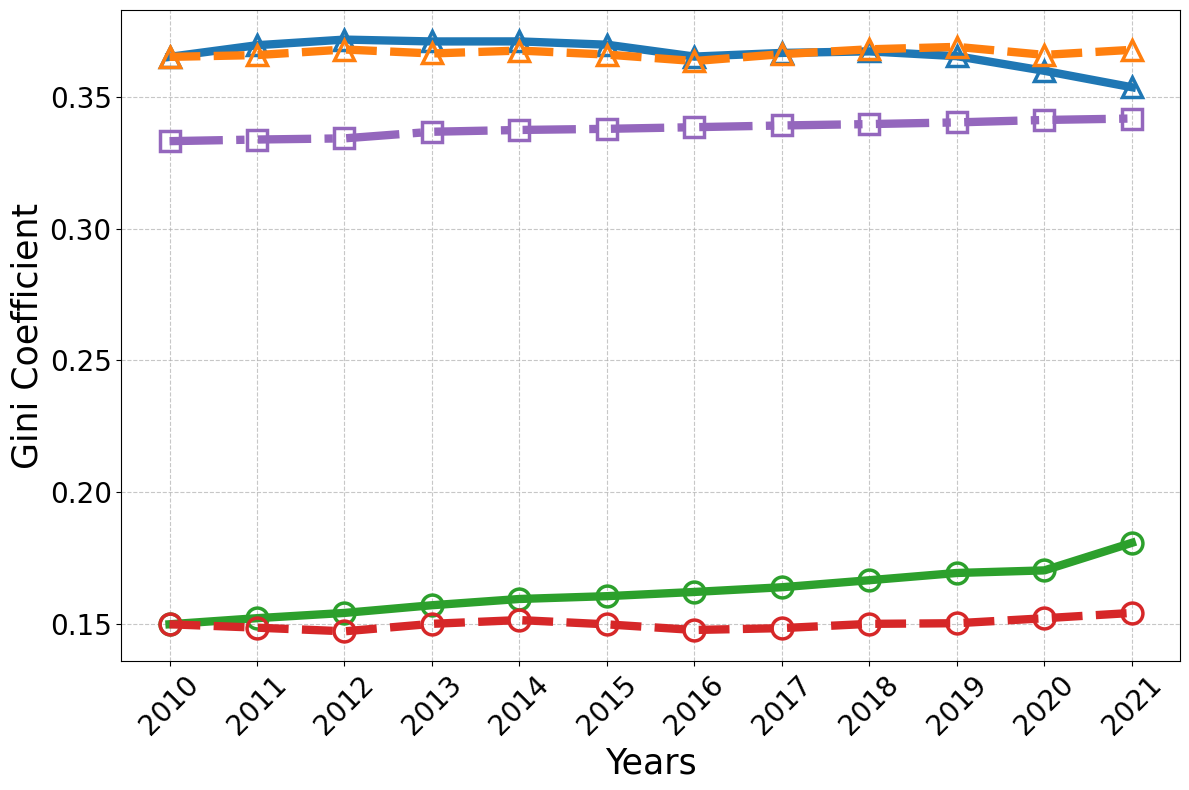

In [ ]:
plt.figure(figsize=(12, 8))

for i, metodo in enumerate(methods):
  plt.plot(
      anos,
    gin_list[metodos[i]],
    label=methods[i],
    color=colors[i],
    ls=linhas[i],
    marker=markers[i],
    markersize=15,
    markerfacecolor='none',  # sem preenchimento
    markeredgecolor=colors[i],  # cor da borda
    markeredgewidth=2.5,
    lw=6)

plt.xlabel('Years', fontsize=25)
plt.ylabel('Gini Coefficient', fontsize=25)
#plt.title('Gini Evolution', fontsize=16)

plt.xticks(anos, rotation=45, fontsize=20)  # Todos os anos e rotação
plt.yticks(fontsize=20)                    # Aumenta tamanho dos ticks do eixo Y

#plt.legend(frameon=False, fontsize=16, loc='best',
#           handlelength=4,  # aumenta o comprimento da linha na legenda
#           handler_map={plt.Line2D: HandlerLine2D(numpoints=3)})

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('gini_evolution',dpi=150)
plt.show()

In [ ]:
gini_mean=[mean(gin_list['p1_fixo']), mean(gin_list['p1_var']), mean(gin_list['p2_fixo']), mean(gin_list['p2_var']), mean(gin_list['atual'])]
np.round(gini_mean, 4)

array([0.3664, 0.3666, 0.1621, 0.1498, 0.3378])

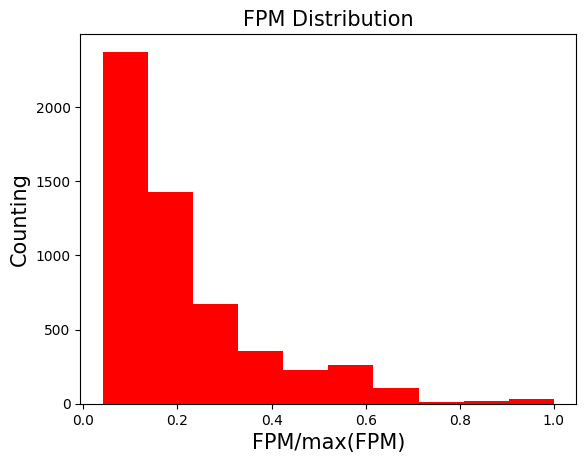

In [ ]:
ano = 2021
plt.hist(np.array(data1[f'FPM_p1_tri{ano}'])/max(data1[f'FPM_p1_tri{ano}']), color='red')
plt.title('FPM Distribution', fontsize=15)
plt.xlabel('FPM/max(FPM)', fontsize=15)
plt.ylabel('Counting', fontsize=15)
plt.show()

In [ ]:
variacao_media = {"p1_fixo": [],
                  "p1_var": [],
                  "p1_tri": [],
                  "p2_fixo": [],
                  "p2_var": [],
                  "p2_tri": []
}

metodos = ['p1_fixo', 'p1_var', 'p1_tri','p2_fixo', 'p2_var', 'p2_tri']

for metodo in metodos:
    for ano in anos:
        data1[f'variacao_{metodo}{ano}'] = data1[f'FPM_{metodo}{ano}'] / data1[f'FPM_atual{ano}']
        variacao_media[metodo].append(data1[f'variacao_{metodo}{ano}'].mean())

/tmp/ipython-input-2703391535.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data1[f'variacao_{metodo}{ano}'] = data1[f'FPM_{metodo}{ano}'] / data1[f'FPM_atual{ano}']
/tmp/ipython-input-2703391535.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  data1[f'variacao_{metodo}{ano}'] = data1[f'FPM_{metodo}{ano}'] / data1[f'FPM_atual{ano}']
/tmp/ipython-input-2703391535.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Cons

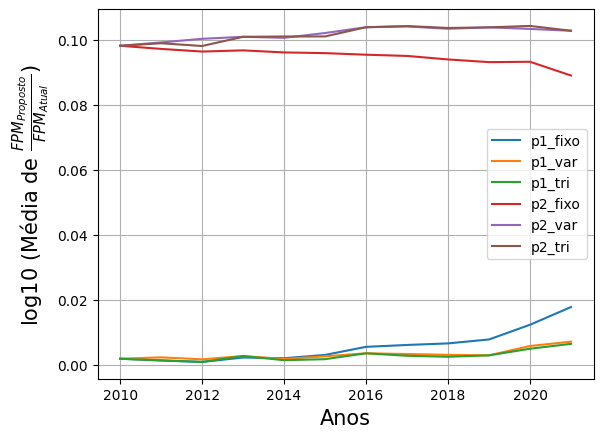

In [ ]:
for metodo in metodos:
    plt.plot(anos, np.log10(variacao_media[metodo]), label=metodo)

plt.xlabel('Anos', fontsize=15)
plt.ylabel('log10 (Média de $\\frac{FPM_{Proposto}}{FPM_{Atual}}$)', fontsize=15)
plt.legend()
plt.grid()
plt.show()

In [ ]:
palma = {"p1_fixo": [],
                  "p1_var": [],
                  "p2_fixo": [],
                  "p2_var": [],
                  "atual": []
}

metodos = ['p1_fixo', 'p1_var', 'p2_fixo', 'p2_var', 'atual']

for metodo in metodos:
    for ano in anos:
        df_sorted = data1.sort_values([f'FPM_{metodo}{ano}']).reset_index(drop=True)
        df_sorted['percentil'] = df_sorted[f'FPM_{metodo}{ano}'].rank(pct=True)
        mais_pobres_40 = df_sorted[df_sorted['percentil'] <= 0.4]
        mais_ricos_10 = df_sorted[df_sorted['percentil'] > 0.9]
        soma_pobres_40 = mais_pobres_40[f'FPM_{metodo}{ano}'].sum()
        soma_ricos_10 = mais_ricos_10[f'FPM_{metodo}{ano}'].sum()
        indice_palma = soma_ricos_10 / soma_pobres_40
        palma[metodo].append(indice_palma)



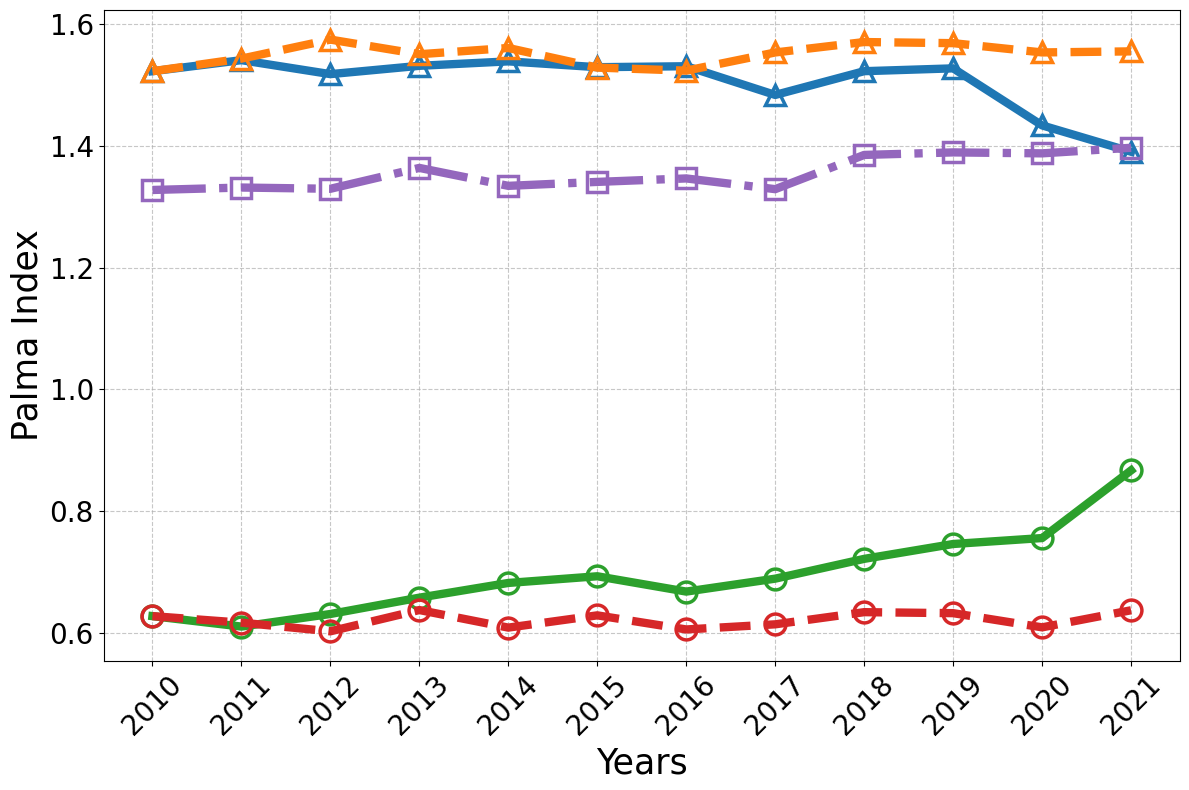

In [ ]:
plt.figure(figsize=(12, 8))

for i, metodo in enumerate(metodos):
    plt.plot(
        anos,
        (palma[metodo]),
        label=methods[i],
        color=colors[i],
        ls=linhas[i],
        marker=markers[i],
        markersize=15,
        markerfacecolor='none',  # sem preenchimento
        markeredgecolor=colors[i],  # cor da borda
        markeredgewidth=2.5,
        lw=6)

plt.xlabel('Years', fontsize=25)
plt.ylabel('Palma Index', fontsize=25)
#plt.title('Palma Evolution', fontsize=6)

plt.xticks(anos, rotation=45, fontsize=20)  # Todos os anos e rotação
plt.yticks(fontsize=20)                    # Aumenta tamanho dos ticks do eixo Y

#plt.legend(frameon=False, fontsize=16, loc='best',
#           handlelength=4,  # aumenta o comprimento da linha na legenda
#           handler_map={plt.Line2D: HandlerLine2D(numpoints=3)})

plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('palma_evolution',dpi=150)
plt.show()

In [ ]:
palma_mean=[mean(palma['p1_fixo']), mean(palma['p1_var']), mean(palma['p2_fixo']), mean(palma['p2_var']), mean(palma['atual'])]
np.round(palma_mean, 4)

array([1.5062, 1.5509, 0.6957, 0.6211, 1.3555])

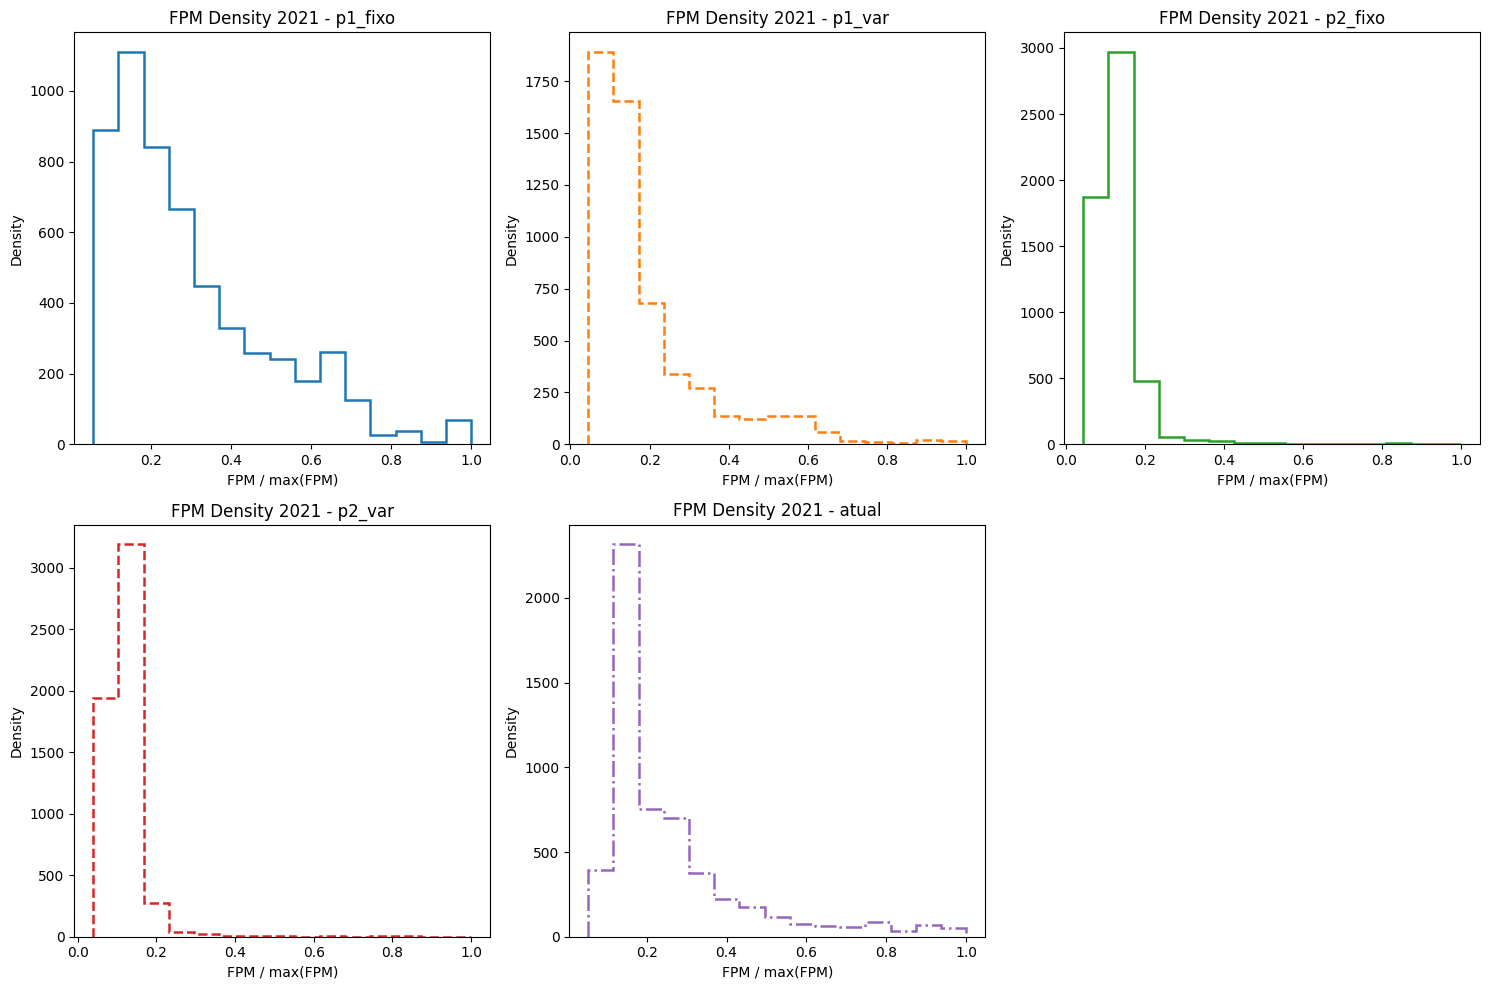

In [ ]:
plt.figure(figsize=(15, 10))

ano = 2021
lins = ['-', '--', '-', '--', 'dashdot']  # estilos de linha

for i, metodo in enumerate(metodos):
    plt.subplot(2, 3, i + 1)
    fpm_normalizado = np.array(data1[f'FPM_{metodo}{ano}']) / max(data1[f'FPM_{metodo}{ano}'])

    plt.hist(fpm_normalizado,
             bins=15,
             density=False,          # Plota como densidade
             histtype='step',       # Só o contorno
             color=colors[i],
             linestyle=lins[i],
             linewidth=1.8)

    plt.title(f'FPM Density {ano} - {metodo}', fontsize=12)
    plt.xlabel('FPM / max(FPM)', fontsize=10)
    plt.ylabel('Density', fontsize=10)

plt.tight_layout()
plt.show()


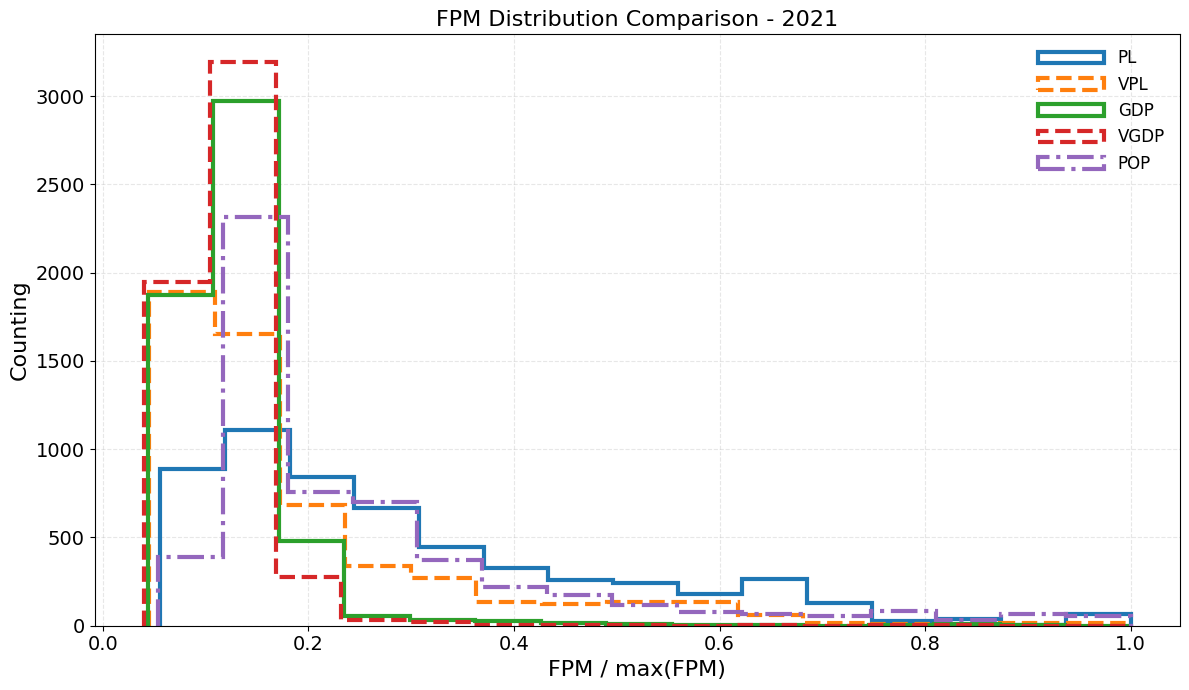

In [ ]:
plt.figure(figsize=(12, 7))

ano = 2021
lins = ['-', '--', '-', '--', 'dashdot']  # Estilos variados

for i, metodo in enumerate(metodos):
    fpm_normalizado = np.array(data1[f'FPM_{metodo}{ano}']) / max(data1[f'FPM_{metodo}{ano}'])

    plt.hist(fpm_normalizado,
             bins=15,
             density=False,
             histtype='step',
             color=colors[i],
             linestyle=lins[i],
             linewidth=3,
             label=methods[i])

plt.title(f'FPM Distribution Comparison - {ano}', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel('FPM / max(FPM)', fontsize=16)
plt.ylabel('Counting', fontsize=16)


plt.legend(frameon=False, fontsize=12, loc='best',
           handlelength=4,  # aumenta o comprimento da linha na legenda
           handler_map={plt.Line2D: HandlerLine2D(numpoints=3)})

plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
plt.savefig('fpm_distribution.png', dpi=300)
plt.show()


In [ ]:
# ============================================================================
# Lista de métodos e anos disponíveis
# ============================================================================
anos = range(2010,2022)  # Substitua pelos anos que você tem
metodos = ["p1_fixo", "p1_var", "p2_fixo", "p2_var", "atual"]

# ============================================================================
# Função: Índice de Theil
# ============================================================================
def theil_index(incomes):
    incomes = np.array(incomes, dtype=np.float64)
    mean_income = np.mean(incomes)
    if mean_income == 0:
        return 0
    incomes = np.where(incomes == 0, 1e-10, incomes)
    return np.sum((incomes / mean_income) * np.log(incomes / mean_income)) / len(incomes)

# ============================================================================
# Função: Decomposição do índice de Theil por estado
# ============================================================================
def theil_decomposition(df, col):
    total_theil = theil_index(df[col])

    grouped = df.groupby('uf')
    rows = []
    theil_within = 0

    for uf, group in grouped:
        weight = len(group) / len(df)
        theil_state = theil_index(group[col])
        contrib = weight * theil_state
        theil_within += contrib

        rows.append({
            'uf': uf,
            'theil_estado': theil_state,
            'peso_estado': weight,
            'contrib_estado': contrib
        })

    theil_between = total_theil - theil_within
    return pd.DataFrame(rows), theil_within, theil_between, total_theil

# ============================================================================
# Cálculo para todos os anos e métodos
# ============================================================================
resultados_estaduais = []
resultados_agregados = []

for metodo in metodos:
    for ano in anos:
        col = f'FPM_{metodo}{ano}'
        if col not in data1.columns:
            print(f"⚠️ Coluna {col} não encontrada. Pulando...")
            continue

        df_estado, tw, tb, tt = theil_decomposition(data1, col)

        df_estado["ano"] = ano
        df_estado["metodo"] = metodo
        resultados_estaduais.append(df_estado)

        resultados_agregados.append({
            'ano': ano,
            'metodo': metodo,
            'theil_within': tw,
            'theil_between': tb,
            'theil_total': tt
        })

# ============================================================================
# DataFrames finais com resultados
# ============================================================================
df_theil_estadual = pd.concat(resultados_estaduais, ignore_index=True)
df_theil_agregado = pd.DataFrame(resultados_agregados)

# ============================================================================
# Exibição opcional
# ============================================================================
print("Resultados estaduais:")
print(df_theil_estadual.head())

print("\nResultados agregados:")
print(df_theil_agregado.head())


Resultados estaduais:
   uf  theil_estado  peso_estado  contrib_estado   ano   metodo
0  AC      0.085888     0.003827        0.000329  2010  p1_fixo
1  AL      0.141571     0.018404        0.002605  2010  p1_fixo
2  AM      0.147238     0.011115        0.001637  2010  p1_fixo
3  AP      0.159646     0.002733        0.000436  2010  p1_fixo
4  BA      0.217062     0.075073        0.016295  2010  p1_fixo

Resultados agregados:
    ano   metodo  theil_within  theil_between  theil_total
0  2010  p1_fixo      0.201261       0.033055     0.234316
1  2011  p1_fixo      0.202470       0.032261     0.234731
2  2012  p1_fixo      0.203065       0.031213     0.234279
3  2013  p1_fixo      0.199231       0.030901     0.230132
4  2014  p1_fixo      0.197395       0.029627     0.227022


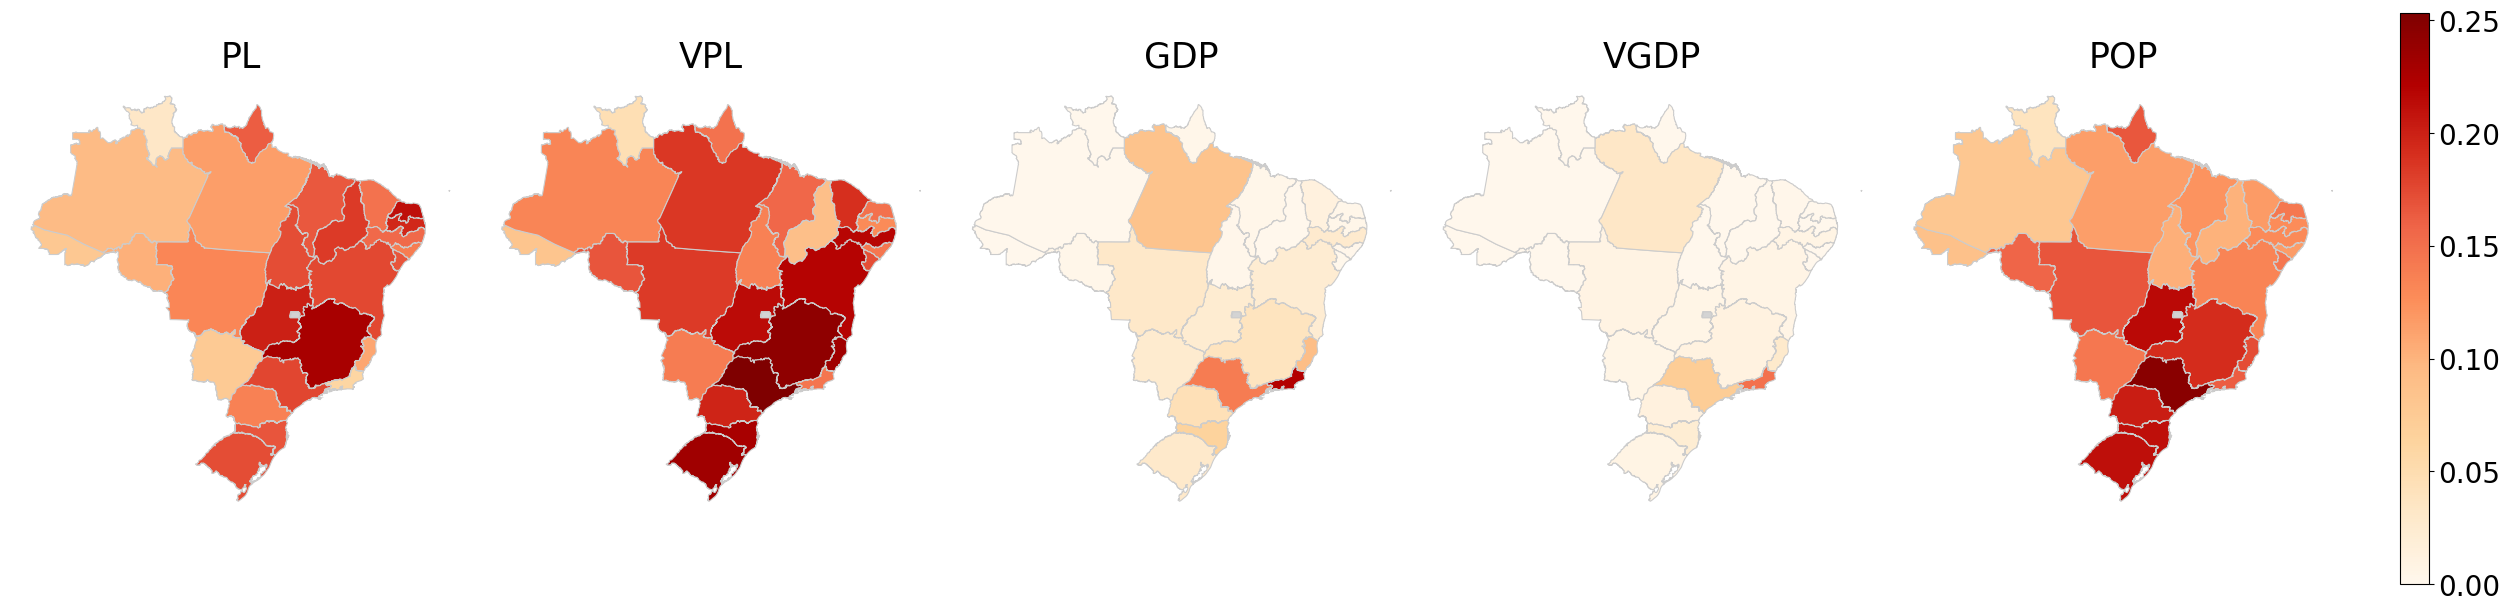

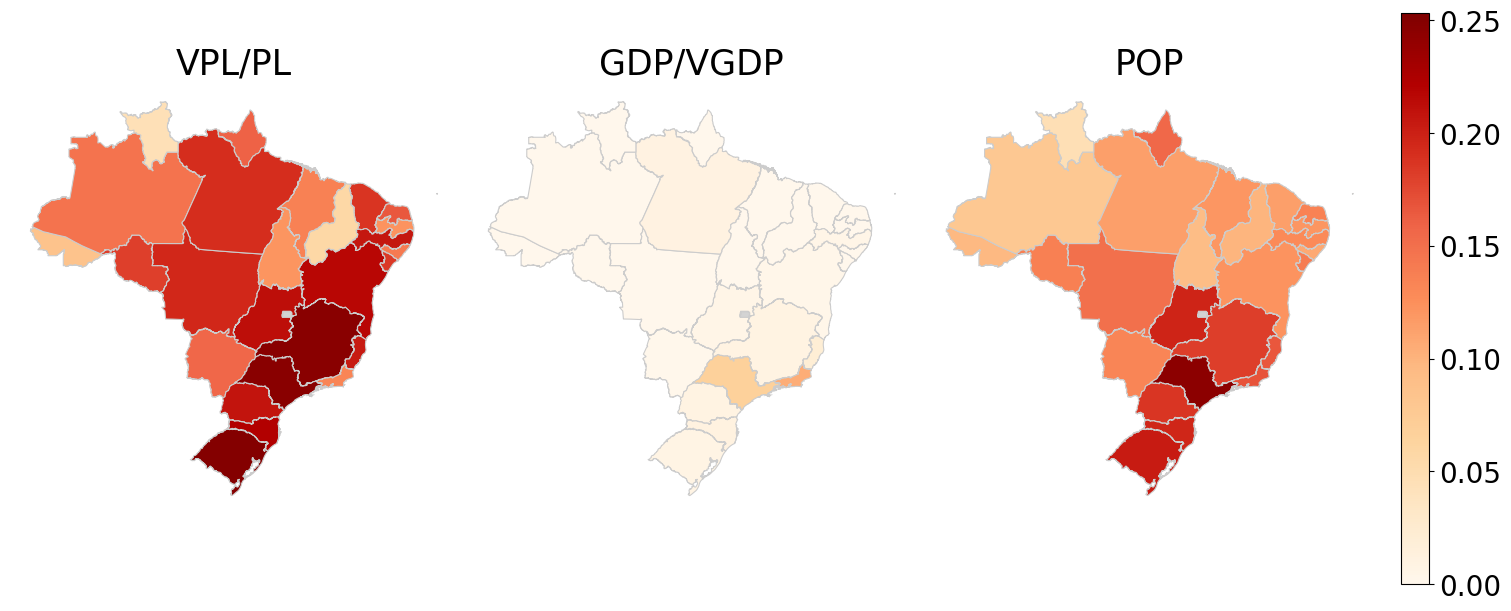

In [ ]:
import geopandas as gpd

# ------------------------------------------------------------------------------
# Carrega e prepara o mapa do Brasil
# ------------------------------------------------------------------------------
url = "https://raw.githubusercontent.com/codeforamerica/click_that_hood/master/public/data/brazil-states.geojson"
br_states = gpd.read_file(url)

uf_map = {
    'Acre': 'AC', 'Alagoas': 'AL', 'Amapá': 'AP', 'Amazonas': 'AM', 'Bahia': 'BA',
    'Ceará': 'CE', 'Distrito Federal': 'DF', 'Espírito Santo': 'ES', 'Goiás': 'GO',
    'Maranhão': 'MA', 'Mato Grosso': 'MT', 'Mato Grosso do Sul': 'MS', 'Minas Gerais': 'MG',
    'Pará': 'PA', 'Paraíba': 'PB', 'Paraná': 'PR', 'Pernambuco': 'PE', 'Piauí': 'PI',
    'Rio de Janeiro': 'RJ', 'Rio Grande do Norte': 'RN', 'Rio Grande do Sul': 'RS',
    'Rondônia': 'RO', 'Roraima': 'RR', 'Santa Catarina': 'SC', 'São Paulo': 'SP',
    'Sergipe': 'SE', 'Tocantins': 'TO'
}
br_states['uf'] = br_states['name'].map(uf_map)

# ------------------------------------------------------------------------------
# Filtra os dados de 2021 e calcula escala global
# ------------------------------------------------------------------------------
df_2021 = df_theil_estadual[df_theil_estadual['ano'] == 2021]
df_2010 = df_theil_estadual[df_theil_estadual['ano'] == 2010]


vmin = min(df_2010['theil_estado'].min(), df_2021['theil_estado'].min())
vmax = max(df_2010['theil_estado'].max(), df_2021['theil_estado'].max())

# ------------------------------------------------------------------------------
# Criação dos subplots com mesma escala de cor
# ------------------------------------------------------------------------------
n_metodos = len(metodos)
metodos_nome = ['PL', 'VPL', 'GDP', 'VGDP', 'POP']

fig, axes = plt.subplots(1, n_metodos, figsize=(5 * n_metodos, 6), constrained_layout=True)

for i, metodo in enumerate(metodos):
    ax = axes[i] if n_metodos > 1 else axes
    df_plot = df_2021[df_2021['metodo'] == metodo][['uf', 'theil_estado']]
    mapa = br_states.merge(df_plot, on='uf', how='left')

    mapa.plot(
        column='theil_estado',
        cmap='OrRd',
        linewidth=0.8,
        edgecolor='0.8',
        legend=False,          # << DESLIGA a barra automática
        vmin=vmin, vmax=vmax,
        ax=ax,
        missing_kwds={"color": "lightgrey", "label": "Sem dados"}
    )

    ax.set_title(f"{metodos_nome[i]}", fontsize=25)
    ax.axis('off')

# ---- colorbar única compartilhada ----
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
sm = mpl.cm.ScalarMappable(cmap='OrRd', norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=axes, fraction=0.03, pad=0.02)
cbar.ax.tick_params(labelsize=20)           # << TICKS FONTSIZE=20
# cbar.set_label('Índice de Theil', fontsize=20)  # (opcional)

plt.savefig('./theil_state_2021.png', dpi=150)
plt.show()


# ===== 2010: consolidar métodos iguais em 3 paineis =====
grupos_2010 = [
    (['p1_fixo', 'p1_var'], 'VPL/PL'),
    (['p2_fixo', 'p2_var'], 'GDP/VGDP'),
    (['atual'],             'POP')
]

fig, axes = plt.subplots(1, len(grupos_2010), figsize=(5 * len(grupos_2010), 6), constrained_layout=True)

for i, (lista_metodos, titulo_grupo) in enumerate(grupos_2010):
    ax = axes[i] if len(grupos_2010) > 1 else axes
    metodo_rep = lista_metodos[0]
    df_plot = df_2010[df_2010['metodo'] == metodo_rep][['uf', 'theil_estado']]
    mapa = br_states.merge(df_plot, on='uf', how='left')

    mapa.plot(
        column='theil_estado',
        cmap='OrRd',
        linewidth=0.8,
        edgecolor='0.8',
        legend=False,          # << DESLIGA
        vmin=vmin, vmax=vmax,
        ax=ax,
        missing_kwds={"color": "lightgrey", "label": "Sem dados"}
    )

    ax.set_title(titulo_grupo, fontsize=25)
    ax.axis('off')

# ---- colorbar única compartilhada ----
norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
sm = mpl.cm.ScalarMappable(cmap='OrRd', norm=norm)
sm.set_array([])

cbar = fig.colorbar(sm, ax=axes, fraction=0.03, pad=0.02)
cbar.ax.tick_params(labelsize=20)           # << TICKS FONTSIZE=20
# cbar.set_label('Índice de Theil (2010)', fontsize=20)  # (opcional)

plt.savefig('./theil_state_2010.png', dpi=150)
plt.show()



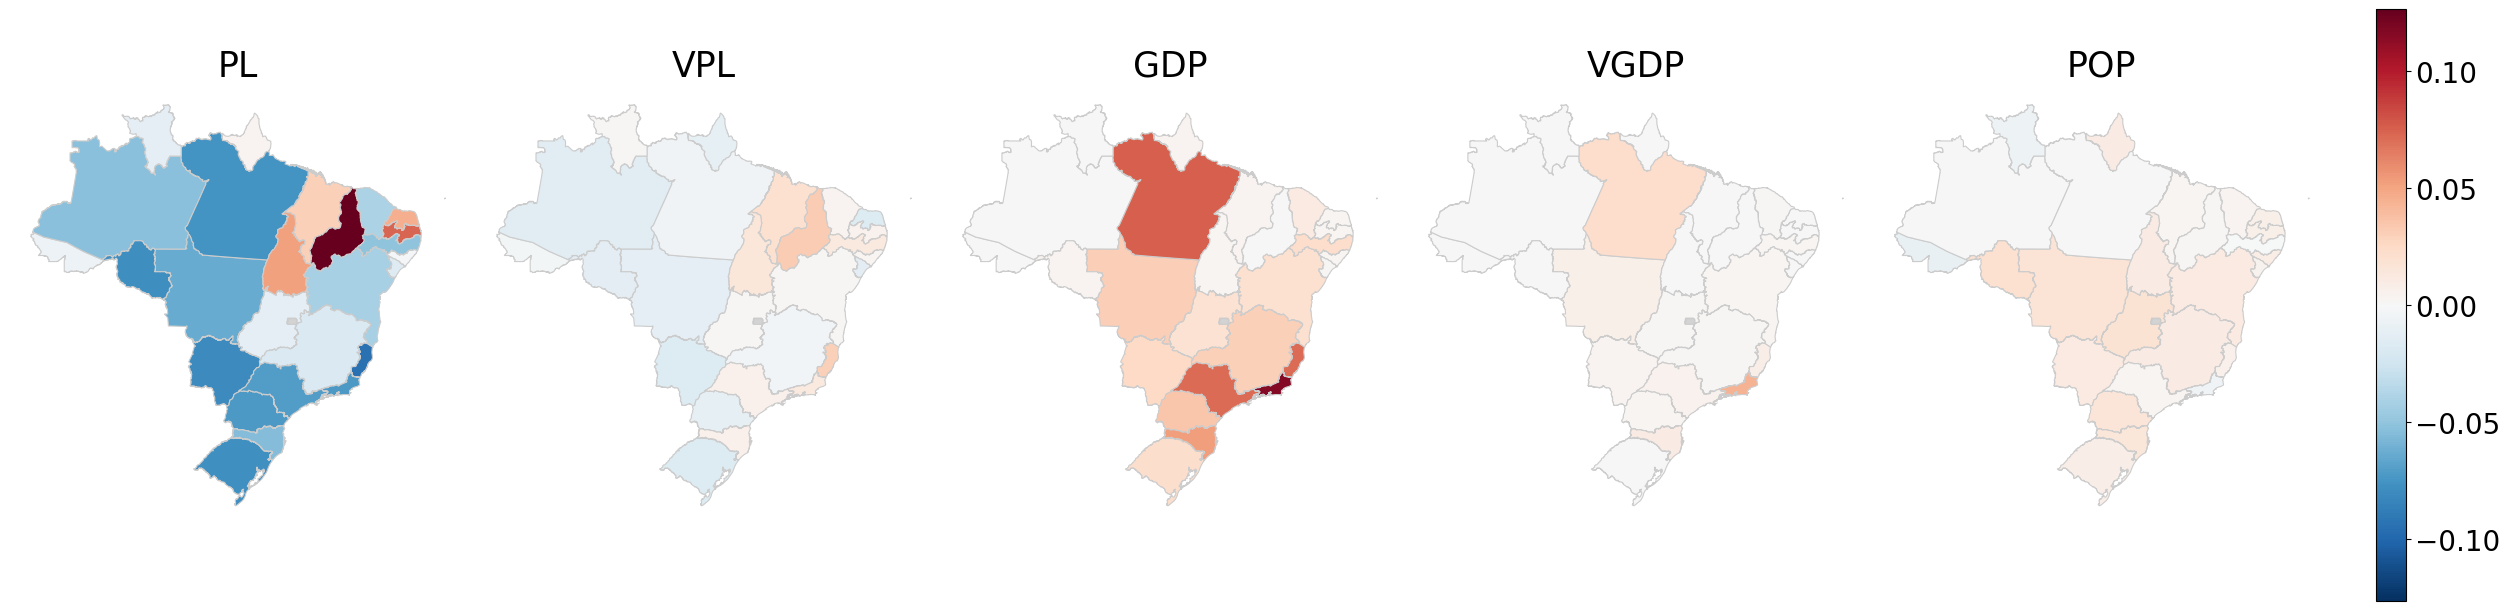

In [ ]:
from matplotlib.colors import TwoSlopeNorm

# ------------------ anos inicial/final ------------------
ANO0, ANO1 = 2010, 2021
# ------------------ separar anos e calcular Δ ------------------
df0 = df_theil_estadual[df_theil_estadual['ano'] == ANO0][['uf','metodo','theil_estado']] \
        .rename(columns={'theil_estado': 'theil_ini'})
df1 = df_theil_estadual[df_theil_estadual['ano'] == ANO1][['uf','metodo','theil_estado']] \
        .rename(columns={'theil_estado': 'theil_fim'})

delta_all = df0.merge(df1, on=['uf','metodo'], how='inner')
delta_all['delta'] = delta_all['theil_fim'] - delta_all['theil_ini']

# ------------------ escala global simétrica em torno de 0 ------------------
maxabs = np.nanmax(np.abs(delta_all['delta'].values))
norm = TwoSlopeNorm(vmin=-maxabs, vcenter=0.0, vmax=maxabs)
cmap = 'RdBu_r'  # azul = aumento, vermelho = queda (inverta para 'RdBu' se preferir o contrário)

# títulos “bonitos”
titulo_por_metodo = dict(zip(metodos, metodos_nome))

# ------------------ figura com 5 painéis ------------------
n_metodos = len(metodos)  # deve ser 5: ['p1_fixo','p1_var','p2_fixo','p2_var','atual']
fig, axes = plt.subplots(1, n_metodos, figsize=(5*n_metodos, 6), constrained_layout=True)

for i, metodo in enumerate(metodos):
    ax = axes[i] if n_metodos > 1 else axes
    df_m = delta_all[delta_all['metodo'] == metodo][['uf','delta']]
    mapa = br_states.merge(df_m, on='uf', how='left')

    mapa.plot(
        column='delta',
        cmap=cmap,
        norm=norm,
        linewidth=0.8,
        edgecolor='0.8',
        ax=ax,
        missing_kwds={"color": "lightgrey", "label": "Sem dados"}
    )

    ax.set_title(f"{titulo_por_metodo.get(metodo, metodo)}", fontsize=25)
    ax.axis('off')

# barra de cores única
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(sm, ax=axes, fraction=0.03, pad=0.02)
cbar.ax.tick_params(labelsize=20)
#cbar.set_label(f'Δ Theil ({ANO1} − {ANO0})', fontsize=12)

plt.savefig(f'./theil_state_delta_{ANO0}_{ANO1}_5painel.png', dpi=150)
plt.show()


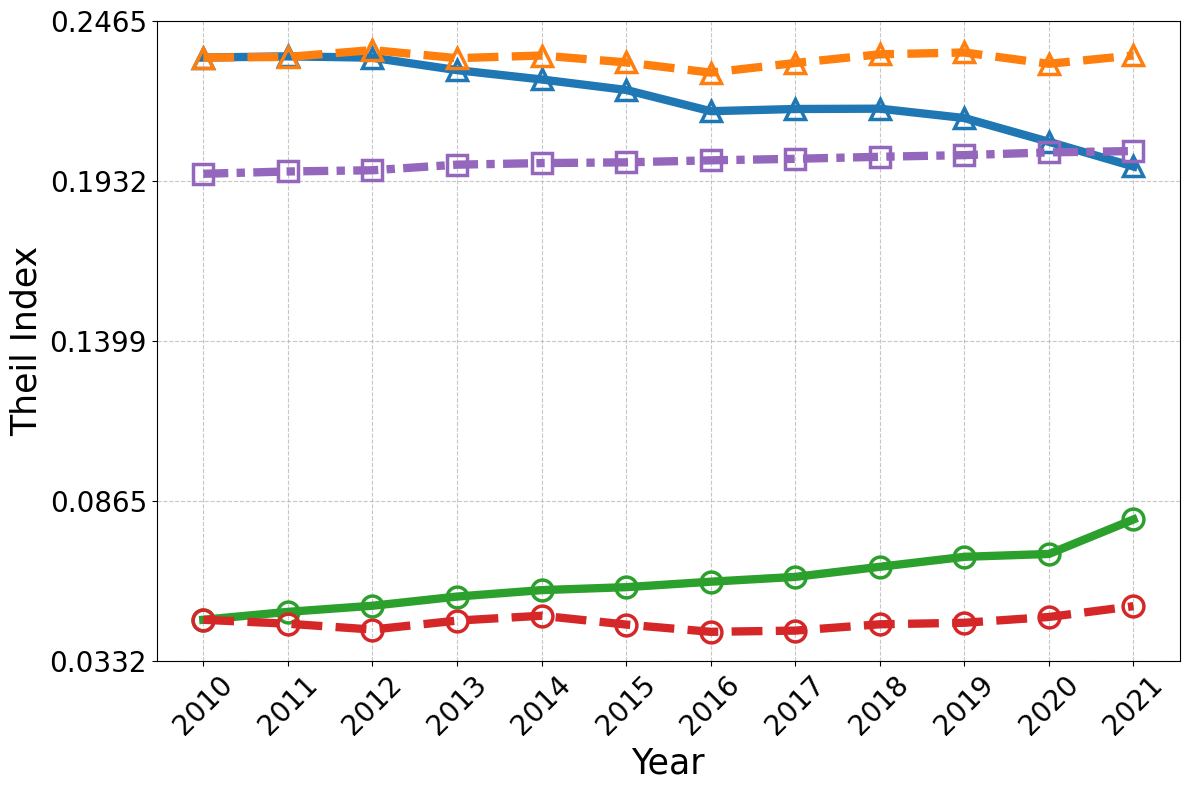

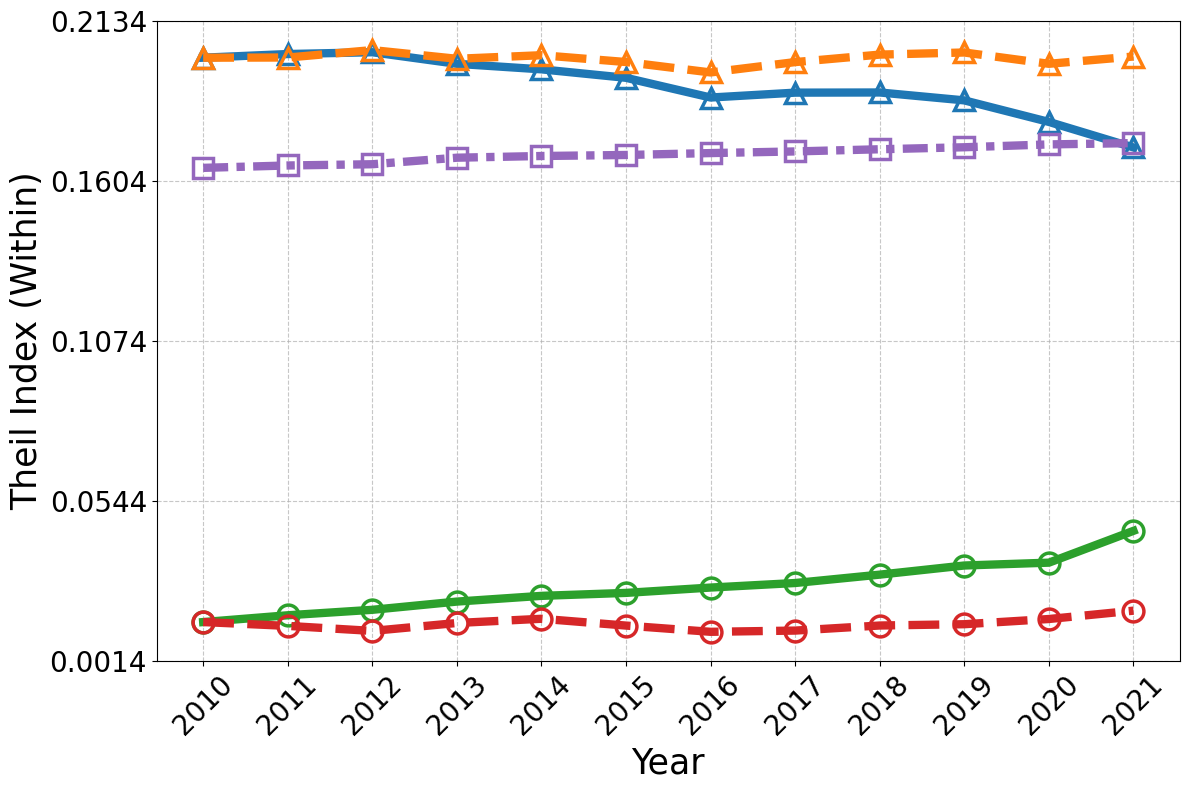

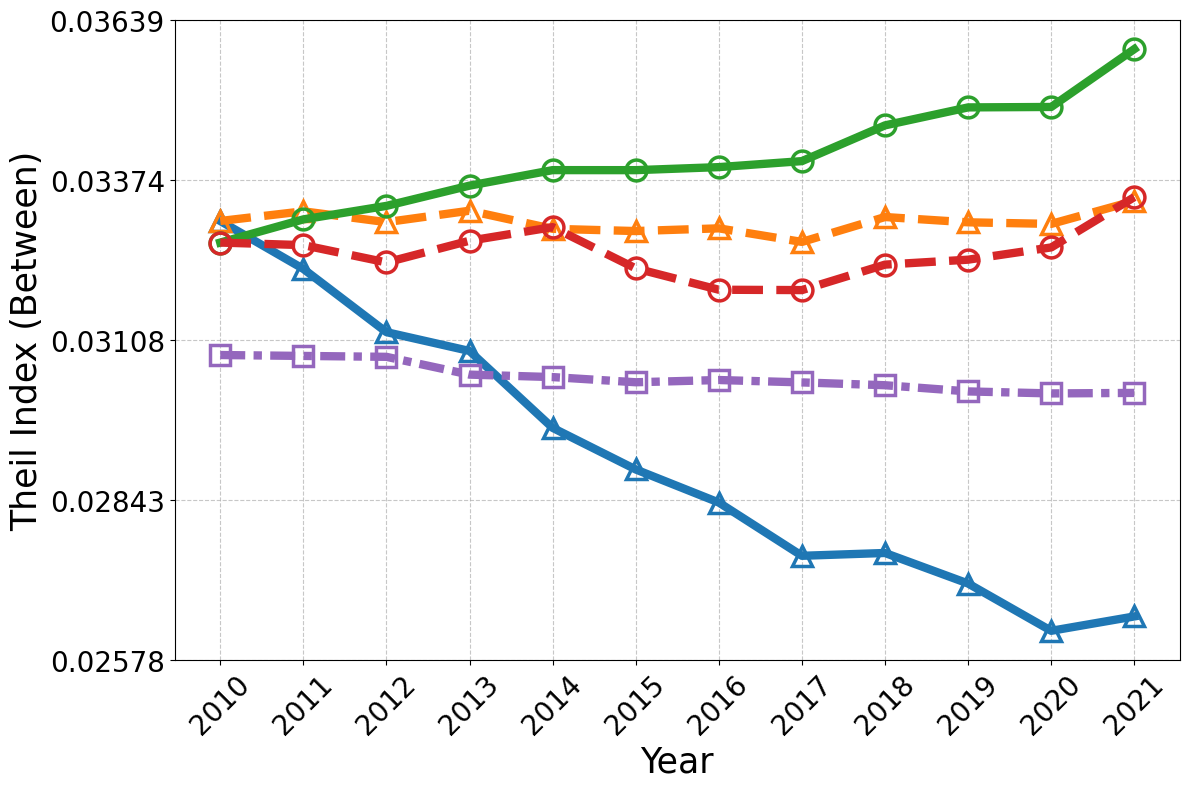

In [ ]:
metodos_labels = dict(zip(metodos, metodos_nome))

estilos = {
    'p1_fixo': 'solid',
    'p1_var': 'dashed',
    'p2_fixo': 'solid',
    'p2_var': 'dashed',
    'atual': (0, (3, 1, 1, 1))
}
cores_metodo = {metodo: color for metodo, color in zip(metodos, colors)}

# Componentes a plotar
componentes = [
    ('theil_total', 'Theil Index', 'theil_total.png'),
    ('theil_within', 'Theil Index (Within)', 'theil_within.png'),
    ('theil_between', 'Theil Index (Between)', 'theil_between.png')
]

# Loop para gerar 3 gráficos separados
for comp, titulo, fname in componentes:
    plt.figure(figsize=(12, 8))
    i=0
    for metodo in metodos:
        df_metodo = df_theil_agregado[df_theil_agregado['metodo'] == metodo]
        plt.plot(
            df_metodo['ano'],
            df_metodo[comp],
            label=metodos_labels[metodo],
            linestyle=estilos[metodo],
            color=cores_metodo[metodo],
            lw=6,
            marker=markers[i],
            markersize=15,  # pontos para dar mais destaque
            markerfacecolor='none',  # sem preenchimento
            markeredgecolor=colors[i],  # cor da borda
            markeredgewidth=2.5,
        )
        i=i+1
    #plt.title(titulo, fontsize=16)
    plt.xlabel("Year", fontsize=25)
    plt.ylabel(titulo, fontsize=25)
    plt.xticks(anos, rotation=45, fontsize=20)  # Todos os anos e rotação
    ymin, ymax = plt.gca().get_ylim()
    yticks = np.linspace(ymin, ymax, 5)   # gera 5 valores igualmente espaçados
    plt.yticks(yticks, fontsize=20)
    plt.grid(True, linestyle='--', alpha=0.7)
    #plt.legend(frameon=False, fontsize=12, loc='best')
    plt.tight_layout()
    plt.savefig(fname, dpi=150)

    plt.show()



In [ ]:
# Cálculo das médias de Theil para cada método
medias_por_metodo = (
    df_theil_agregado
    .groupby("metodo")[["theil_total", "theil_within", "theil_between"]]
    .mean()
)

print(round(medias_por_metodo,4))


         theil_total  theil_within  theil_between
metodo                                           
atual         0.1996        0.1692         0.0305
p1_fixo       0.2211        0.1920         0.0291
p1_var        0.2340        0.2010         0.0330
p2_fixo       0.0600        0.0259         0.0341
p2_var        0.0461        0.0136         0.0325


/tmp/ipython-input-2629256729.py:13: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(dados_normalizados,


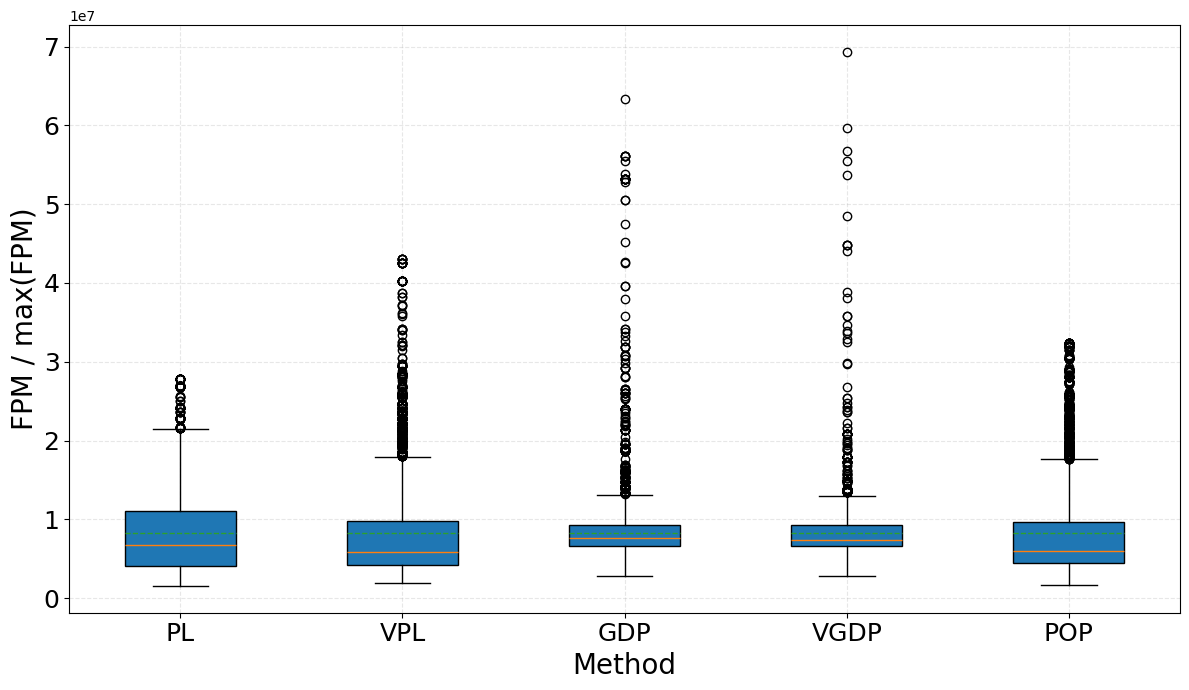

In [ ]:
plt.figure(figsize=(12, 7))

ano = 2021

# Preparar os dados normalizados de cada método
dados_normalizados = []
for metodo in metodos:
    #fpm_normalizado = np.array(data1[f'FPM_{metodo}{ano}']) / max(data1[f'FPM_{metodo}{ano}'])
    fpm_normalizado = np.array(data1[f'FPM_{metodo}{ano}'])
    dados_normalizados.append(fpm_normalizado)

# Criar o boxplot
plt.boxplot(dados_normalizados,
            labels=methods,   # nomes dos métodos
            patch_artist=True,
            notch=False,
            showmeans=True,   # mostra a média
            meanline=True)    # linha no lugar de ponto da média

#plt.title(f'FPM Distribution Comparison - {ano}', fontsize=16)
plt.xticks(fontsize=18)
plt.yticks(fontsize=18)

plt.xlabel('Method', fontsize=20)
plt.ylabel('FPM / max(FPM)', fontsize=20)

plt.grid(alpha=0.3, linestyle='--')
plt.tight_layout()
#plt.savefig('fpm_boxplot.png', dpi=300)
plt.show()


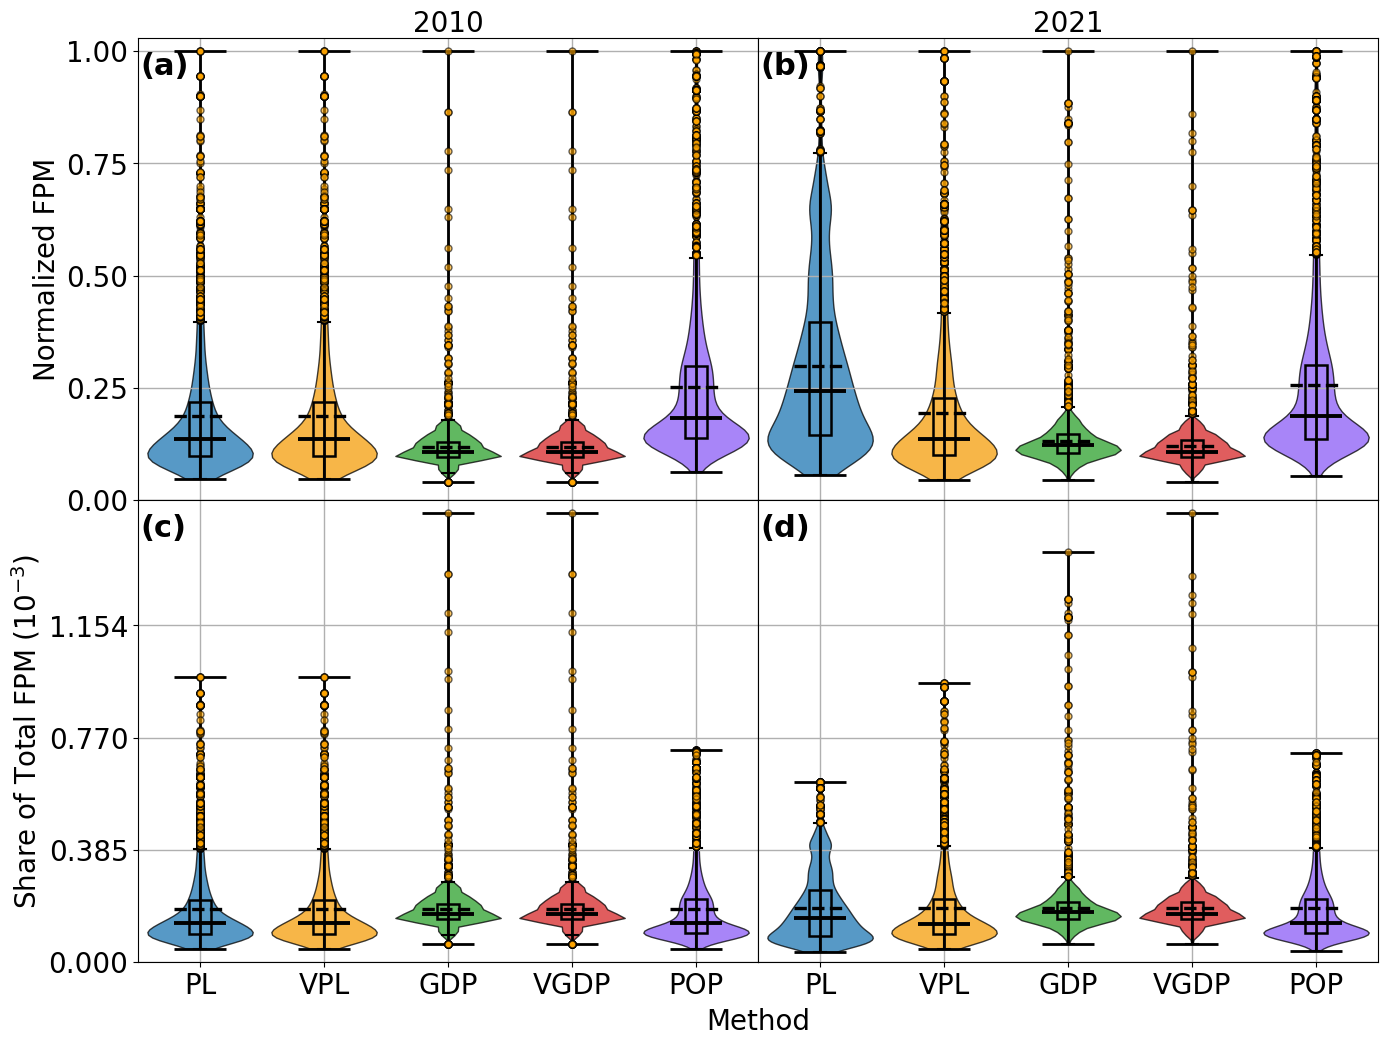

In [ ]:
def plot_violin(ax, series_list, methods, method_colors, edgecolor='black', widths=1.0):
    parts = ax.violinplot(series_list, showmeans=True, showmedians=True, widths=widths)

    # cores por MÉTODO (bodies)
    for k, pc in enumerate(parts['bodies']):
        m = methods[k]
        pc.set_facecolor(method_colors[m])
        pc.set_edgecolor(edgecolor)
        pc.set_alpha(0.75)

    # Mediana: preta, contínua, mais grossa
    parts['cmedians'].set_color('black')
    parts['cmedians'].set_linestyle('-')
    parts['cmedians'].set_linewidth(2.8)

    # Média: preta, tracejada
    parts['cmeans'].set_color('black')
    parts['cmeans'].set_linestyle('--')
    parts['cmeans'].set_linewidth(2.4)

    # Demais linhas (extremos/barras) em preto
    for key in ['cbars', 'cmins', 'cmaxes']:
        parts[key].set_linewidth(2.0)
        parts[key].set_color('black')

    # Sobrepor BOXPlot apenas com quartis, whiskers e outliers
    ax.boxplot(
        series_list,
        positions=np.arange(1, len(series_list) + 1),
        widths=0.18,
        patch_artist=True,
        boxprops=dict(facecolor='none', edgecolor='black', linewidth=1.8),
        medianprops=dict(color='black', linewidth=0),  # mediana já mostrada pelo violino
        whiskerprops=dict(color='black', linewidth=1.5),
        capprops=dict(color='black', linewidth=1.5),
        flierprops=dict(marker='o', markersize=5, markerfacecolor='orange',
                        markeredgecolor='black', alpha=0.6)
    )

    return parts



def set_y_from_zero_with_max4ticks(ax, series_list, show_ticks=True, hide_last=False, headroom=0.03):
    # Mantemos SEMPRE os ticks (para o grid funcionar em todos os painéis)
    ymax = max(float(np.max(s)) if len(s) else 0.0 for s in series_list)
    ymax = 0.0 if not np.isfinite(ymax) else ymax
    if ymax <= 0:
        ymax = 1.0
    ticks = np.linspace(0, ymax, 5)
    if hide_last:  # remove apenas o último tick (para não colidir com o painel de cima)
        ticks = ticks[:-1]
    ax.set_ylim(0, ymax * (1.0 + headroom))
    ax.set_yticks(ticks)  # sempre define os ticks (mesmo quando não quisermos mostrá-los)

# ANOS por COLUNA (esq=2010, dir=2021)
col_years = [2010, 2021]
labels_panel = ['(a)', '(b)', '(c)', '(d)']
tick_fs = 20

# Paleta por MÉTODO seguindo a ordem da legenda: PL (azul), VPL (laranja),
# GDP (verde), VGDP (vermelho), POP (roxo)
palette = ['#1f77b4', '#f59e0b', '#2ca02c', '#d62728', '#8b5cf6']
method_colors = {m: c for m, c in zip(methods, palette)}

fig, axes = plt.subplots(2, 2, figsize=(16, 12), sharex=False, sharey=False)
plt.subplots_adjust(wspace=0, hspace=0)

for i in [0, 1]:       # i=0 -> linha de cima, i=1 -> linha de baixo
    for j in [0, 1]:   # j=0 -> coluna esquerda (2010), j=1 -> coluna direita (2021)
        ax = axes[i, j]
        year = col_years[j]

        # dados (topo: normalizado pelo máx; base: share * 1000)
        series = []
        for metodo in metodos:
            fpm = np.array(data1[f'FPM_{metodo}{year}'])
            if i == 0:
                denom = fpm.max() if fpm.max() != 0 else 1.0
                fpm_n = fpm / denom
            else:
                total = fpm.sum()
                fpm_n = (fpm / total if total != 0 else fpm) * 1000.0
            series.append(fpm_n)

        # plot (violinos mais largos e menos margem no eixo x)
        plot_violin(ax, series, methods, method_colors, widths=0.85)
        ax.set_xticks(np.arange(1, len(methods) + 1))
        ax.margins(x=0.02)

        if i == 0:
            ax.set_xticklabels([])                     # sem rótulos na linha de cima
        else:
            ax.set_xticklabels(methods, fontsize=tick_fs)  # rótulos nos DOIS painéis de baixo

        # eixo Y (direita sem mostrar; esquerda mostra)
        if j == 1:
            set_y_from_zero_with_max4ticks(ax, series, show_ticks=False, hide_last=(i == 1), headroom=0.03)
            ax.tick_params(axis='y', left=False, right=False, labelleft=False, labelright=False)
        else:
            set_y_from_zero_with_max4ticks(ax, series, show_ticks=True, hide_last=(i == 1), headroom=0.03)
            ax.tick_params(axis='y', labelsize=tick_fs)

        # GRID consistente em todos
        ax.yaxis.grid(True, which='major', linestyle='-', linewidth=1.0, alpha=1.0)
        ax.xaxis.grid(True, which='major', linestyle='-', linewidth=1.0, alpha=1.0)

        # títulos: apenas no topo, por COLUNA (esq=2010, dir=2021)
        if i == 0:
            ax.set_title(f'{year}', fontsize=20, pad=4)
        else:
            ax.set_title("")

        # y-labels só à esquerda
        if i == 0 and j == 0:
            ax.set_ylabel('Normalized FPM', fontsize=20)
        elif i == 1 and j == 0:
            ax.set_ylabel('Share of Total FPM ($10^{-3}$)', fontsize=20)
        else:
            ax.set_ylabel(None)

        ax.set_xlabel(None)  # sem xlabel nos painéis

        # (a)…(d)
        idx = i * 2 + j
        ax.text(0.004, 0.97, labels_panel[idx],
                transform=ax.transAxes, ha='left', va='top',
                fontsize=22, fontweight='bold')

# "Method" como TEXTO central entre as duas colunas, abaixo dos ticks X
posL = axes[1, 0].get_position()
posR = axes[1, 1].get_position()
center_x = (posL.x0 + posR.x1) / 2.0
label_y  = posL.y0 - 0.1 * (posL.y1 - posL.y0)
fig.text(center_x, label_y, 'Method', ha='center', va='top', fontsize=20)

plt.savefig('fpm_violin.png', dpi=300, bbox_inches='tight')
plt.show()
